**Installing Some Libraries**

In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstal

In [1]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 7.6 MB/s eta 0:00:00


**Important All Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas_ta
import datetime as dt
import yfinance as yf
import sklearn

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import warnings
warnings.filterwarnings("ignore")

## Downloading data

We got the list of S&P 500 stocks form wikipedia on the internet

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', storage_options=headers)[0]

In [4]:
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


**Enhancing the data**

In [5]:
# removing dot from the symbols to avoid any issue during downloading the data
sp500["Symbol"] = sp500["Symbol"].str.replace("." , "-")


# creating a list for the symbols
symbol_list = sp500["Symbol"].unique().tolist()

In [6]:
len(symbol_list)

503

**The Period that we are interested on (Ten Years)**

In [7]:
End_date = "2025-12-31"

Start_date = pd.to_datetime(End_date)-pd.DateOffset(365*10)

In [8]:
print(f"starting date: {Start_date}, while ending date: {End_date}")

starting date: 2016-01-03 00:00:00, while ending date: 2025-12-31


**Getting the data of the S&P500 list**

In [9]:
df = yf.download(tickers=symbol_list, start=Start_date, end=End_date,
                    multi_level_index=False)

[*********************100%***********************]  503 of 503 completed


In [10]:
df.head()

Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2016-01-04  37.569218  23.730946  37.707535  NaN  35.380215  21.823122   
2016-01-05  37.439953  23.136265  37.550453  NaN  35.371979  21.902363   
2016-01-06  37.606155  22.683500  37.556984  NaN  35.075298  21.937229   
2016-01-07  36.008842  21.726151  37.445728  NaN  34.234657  21.915041   
2016-01-08  35.630283  21.841040  36.424656  NaN  33.517670  21.686827   

Price                                                   ...   Volume           \
Ticker            ACN       ADBE        ADI        ADM  ...       WY     WYNN   
Date                                                    ...                     
2016-01-04  86.944160  91.970001  44.674232  26.596720  ...  3556800  4249800   
2016-01-05  87.396698  92.339996  44.345997  26.893553  ...  2722800  4286100   
2016-01-06  87.225945  91.019997  42.458572  26.240517  ...  4843200  3316100   
2016-01-07  84.664505  89.110001  41.375362  25.617149  ...  4917400  5525600   
2016-01-08  83.844818  87.849998  41.014309  25.520676  ...  5022600  5740000   

Price                                                                        \
Ticker          XEL       XOM      XYL      XYZ       YUM      ZBH     ZBRA   
Date                                                                          
2016-01-04  2819300  20400100  1353400  2751500   4821623  2104084   656200   
2016-01-05  2141200  11993500  1075400  2352800   5273420  2294737   611300   
2016-01-06  5191900  18826900  1866000  1850600   5049330  2751233   881900   
2016-01-07  5212200  21263800  1555400  1636000  11005453  1829589  1210600   
2016-01-08  3005400  19033600  1471500   587300   5996184  1670969  1034700   

Price                
Ticker          ZTS  
Date                 
2016-01-04  2871700  
2016-01-05  3116700  
2016-01-06  4670500  
2016-01-07  4324400  
2016-01-08  4946100  

[5 rows x 2515 columns]

**Stacking the df to make it more easier to read**

In [11]:
df = df.stack()

In [12]:
df.head()

Price                  Close       High        Low       Open       Volume
Date       Ticker                                                         
2016-01-04 A       37.569218  38.030869  37.246063  37.910843    3287300.0
           AAPL    23.730946  23.735452  22.976331  23.113739  270597600.0
           ABBV    37.707535  38.172251  36.915553  38.002074   10308400.0
           ABNB          NaN        NaN        NaN        NaN          NaN
           ABT     35.380215  36.303248  35.025835  36.212592   12227500.0

**Looking at our columns & index**

In [13]:
print(f"column names: {df.columns}")
print("-"*30)
print(f"index names{df.index.names}")

column names: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='str', name='Price')
------------------------------
index names['Date', 'Ticker']


In [14]:
df.columns = df.columns.str.lower()
df.index.names = ["date", "ticker"]

In [15]:
df.tail()

Price                   close        high         low        open     volume
date       ticker                                                           
2025-12-30 XYZ      65.540001   65.989998   65.449997   65.830002  2958800.0
           YUM     152.179993  152.660004  151.449997  151.679993  1158600.0
           ZBH      90.790001   90.919998   89.879997   90.180000   934500.0
           ZBRA    246.740005  247.039993  243.320007  244.619995   492400.0
           ZTS     125.872520  127.057456  124.916596  125.016176  3230200.0

## Calculating Technical Indicators for Each Stock

In [16]:
"""

The Technical Indicators we will focus on are:

  1- Garman-Klass Volatility
  2- RSI (Relative Strength Index)
  3- Bollinger Bands
  4- ATR (Average True Range)
  5- MACD
  6- Dollar Volume

"""

'\n\nThe Technical Indicators we will focus on are:\n\n  1- Garman-Klass Volatility\n  2- RSI (Relative Strength Index)\n  3- Bollinger Bands\n  4- ATR (Average True Range)\n  5- MACD\n  6- Dollar Volume\n\n'

**1- Garman-Klass Volatility**

It is an improved historical volatility estimator that uses daily open, high, low, and closing (OHLC) prices to measure asset volatility

In [17]:
df["garman_klass_vol"] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

In [18]:
df.head()

Price                  close       high        low       open       volume  \
date       ticker                                                            
2016-01-04 A       37.569218  38.030869  37.246063  37.910843    3287300.0   
           AAPL    23.730946  23.735452  22.976331  23.113739  270597600.0   
           ABBV    37.707535  38.172251  36.915553  38.002074   10308400.0   
           ABNB          NaN        NaN        NaN        NaN          NaN   
           ABT     35.380215  36.303248  35.025835  36.212592   12227500.0   

Price              garman_klass_vol  
date       ticker                    
2016-01-04 A               0.000186  
           AAPL            0.000260  
           ABBV            0.000537  
           ABNB                 NaN  
           ABT             0.000433

**2- RSI**

It's a momentum indicator

In [19]:
"""
level=1 is the ticker, whereas lever=0 is the date
"""

df["rsi"] = df.groupby(level=1)["close"].transform(lambda x: pandas_ta.rsi(close=x, length=15))

In [20]:
df.tail()

Price                   close        high         low        open     volume  \
date       ticker                                                              
2025-12-30 XYZ      65.540001   65.989998   65.449997   65.830002  2958800.0   
           YUM     152.179993  152.660004  151.449997  151.679993  1158600.0   
           ZBH      90.790001   90.919998   89.879997   90.180000   934500.0   
           ZBRA    246.740005  247.039993  243.320007  244.619995   492400.0   
           ZTS     125.872520  127.057456  124.916596  125.016176  3230200.0   

Price              garman_klass_vol        rsi  
date       ticker                               
2025-12-30 XYZ             0.000026  51.529266  
           YUM             0.000027  53.895839  
           ZBH             0.000049  46.038575  
           ZBRA            0.000086  39.062214  
           ZTS             0.000126  55.982708

**3- Bollinger Bands**

It's used measure market volatility and identify overbought or oversold conditions

In [21]:
# for lower band
df["bb_low"] = df.groupby(level=1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

# for mid band
df["bb_mid"] = df.groupby(level=1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

# for higher band
df["bb_high"] = df.groupby(level=1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [22]:
df.tail()

Price                   close        high         low        open     volume  \
date       ticker                                                              
2025-12-30 XYZ      65.540001   65.989998   65.449997   65.830002  2958800.0   
           YUM     152.179993  152.660004  151.449997  151.679993  1158600.0   
           ZBH      90.790001   90.919998   89.879997   90.180000   934500.0   
           ZBRA    246.740005  247.039993  243.320007  244.619995   492400.0   
           ZTS     125.872520  127.057456  124.916596  125.016176  3230200.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid   bb_high  
date       ticker                                                             
2025-12-30 XYZ             0.000026  51.529266  4.110362  4.169891  4.229420  
           YUM             0.000027  53.895839  4.961359  5.018173  5.074986  
           ZBH             0.000049  46.038575  4.493392  4.526104  4.558815  
           ZBRA            0.000086  39.062214  5.482913  5.554163  5.625413  
           ZTS             0.000126  55.982708  4.754446  4.806522  4.858599

**4- ATR**

It's used to measures market volatility by calculating the average range

In [23]:
"""
group_keys=False to avoid having double date raws
"""

def compute_atr(data):
  atr = pandas_ta.atr(high=data["high"],
                      low=data["low"],
                      close=data["close"],
                      length=14)

  return atr.sub(atr.mean()).div(atr.std())

df["atr"] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [24]:
df.sample(3)

,Price,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr
date,ticker,,,,,,,,,,,
2021-06-28,ALB,160.098282,161.897665,157.181376,158.942883,670700.0,0.000417,55.530694,5.019380,5.072487,5.125594,-0.017017
2020-04-23,RL,62.310871,62.970583,60.241379,60.828786,927100.0,0.000758,43.008280,4.038210,4.167362,4.296515,0.696894
2019-01-08,YUM,80.160515,80.828668,79.087956,80.591294,2604700.0,0.000226,53.302120,4.351991,4.387228,4.422466,0.013931


**5- MACD**

It's a trend-following momentum indicator

In [25]:
def compute_macd(data):
  macd = pandas_ta.macd(close=data["close"],
                      length=14).iloc[:,0]

  return macd.sub(macd.mean()).div(macd.std())


df["macd"] = df.groupby(level=1, group_keys=False).apply(compute_macd)

In [26]:
df.sample(3)

,Price,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd
date,ticker,,,,,,,,,,,,
2016-08-30,HUM,165.205322,165.353434,163.067014,163.400258,603800.0,0.000050,54.115496,5.090320,5.112491,5.134663,-1.424538,0.143396
2021-03-17,EG,229.650467,233.598619,227.274263,233.598619,225400.0,0.000264,61.624040,5.367061,5.412497,5.457932,0.053330,1.131155
2025-01-06,LYV,129.270004,130.630005,129.110001,129.429993,1575600.0,0.000068,41.769024,4.858789,4.899451,4.940114,0.267213,-0.463270


**6- Dollar Volume**

It's the total monetary value of an asset traded over a specific period

In [27]:
df["dollar_volume"] = (df["close"] * df['volume'])/1e6

In [28]:
df.sample(3)

,Price,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,ticker,,,,,,,,,,,,,
2020-12-16,AMP,175.221130,177.936150,174.408463,177.539060,790700.0,0.000134,56.341514,5.125564,5.172923,5.220282,-0.418838,0.544817,138.547348
2017-06-13,CDNS,34.400002,34.740002,34.349998,34.459999,2156000.0,0.000063,54.473026,3.507112,3.565784,3.624455,-1.061256,-0.090353,74.166403
2016-11-16,PEP,76.887329,77.786907,76.705904,77.378696,3962900.0,0.000082,33.214156,4.352195,4.393144,4.434093,-0.832761,-0.784137,304.696796


In [29]:
len(df)

1264039

## Aggregate To Monthly Level & Filter Top 100 Most Liquid Stocks For Each Month

### Aggregating To Monthly Level

For dollar volume column, we want to get the average of the month

For the five technical indicators, we want to get the last value of the month

In [30]:
# Getting the feature names

columns_features = [c for c in df.columns.unique(0) if c not in ["dollar_volume",
                                                         "high", "low",
                                                         "open", "volume"]]

In [31]:
data = (pd.concat([df.unstack("ticker")["dollar_volume"].resample("ME").mean().stack("ticker").to_frame("dollar_volume"),
          df.unstack()[columns_features].resample("ME").last().stack("ticker")], axis=1)).dropna()

In [32]:
data.head()

dollar_volume      close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 A           90.555690  34.485382          0.000033  48.482126   
           AAPL      3511.593549  21.898401          0.000130  42.774425   
           ABBV       330.124290  36.119358          0.000183  47.087800   
           ABT        235.380209  32.128563          0.000301  48.458709   
           ACGL        29.994184  21.534683          0.000102  51.887571   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.506736  3.556798  3.606859 -1.152181 -0.210487  
           AAPL    3.095747  3.120842  3.145937 -1.122929 -0.317727  
           ABBV    3.561206  3.610388  3.659571 -0.811233 -0.315636  
           ABT     3.440393  3.485063  3.529734 -1.027377 -0.398828  
           ACGL    3.086290  3.113903  3.141516 -0.818135 -0.115047

### Filtering top 200 liquid stocks

In [33]:
# we want to rank the data based on the dollar volume

data["dollar_volume"] = (data.loc[:, "dollar_volume"].unstack("ticker").rolling(window=5*12,
                                                                                min_periods=12).mean().stack())

In [34]:
len(data)

58143

In [35]:
data.tail()

dollar_volume       close  garman_klass_vol        rsi  \
date       ticker                                                           
2025-12-31 XYZ       1115.115344   65.540001          0.000026  51.529266   
           YUM        224.131914  152.179993          0.000027  53.895839   
           ZBH        181.466212   90.790001          0.000049  46.038575   
           ZBRA       139.217513  246.740005          0.000086  39.062214   
           ZTS        387.431674  125.872520          0.000126  55.982708   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2025-12-31 XYZ     4.110362  4.169891  4.229420 -0.605224 -0.024838  
           YUM     4.961359  5.018173  5.074986  0.969864  0.892257  
           ZBH     4.493392  4.526104  4.558815 -0.755083 -0.442485  
           ZBRA    5.482913  5.554163  5.625413 -0.229021 -0.566248  
           ZTS     4.754446  4.806522  4.858599 -0.044603 -0.068038

In [36]:
# here we rank the data by the date

data["dollar_vol_rank"] = (data.groupby("date")["dollar_volume"].rank(ascending=False))

In [183]:
new_data = data[data['dollar_vol_rank']<100].drop(["dollar_vol_rank","dollar_volume"],axis=1)

In [184]:
new_data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-01-31 AAPL     27.943262          0.000019  69.493972  3.321736   
           ABBV     41.963844          0.000209  48.690042  3.737573   
           ABT      35.518665          0.000172  71.654473  3.533926   
           ACN      99.189308          0.000077  38.951868  4.607716   
           ADBE    113.379997          0.000042  67.601666  4.648914   
...                       ...               ...        ...       ...   
2025-12-31 VZ       40.005905          0.000026  51.907735  3.686362   
           WFC      93.848747          0.000037  66.331765  4.475803   
           WMT     111.919998          0.000029  52.108680  4.713338   
           XOM     120.188896          0.000046  61.525346  4.743675   
           XYZ      65.540001          0.000026  51.529266  4.110362   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-01-31 AAPL    3.350973  3.380211 -1.257597 -0.137081  
           ABBV    3.769558  3.801544 -1.173743 -0.341895  
           ABT     3.568056  3.602185 -1.347879  0.176230  
           ACN     4.623076  4.638435 -1.223585 -0.294158  
           ADBE    4.706909  4.764903 -1.475470  0.170649  
...                     ...       ...       ...       ...  
2025-12-31 VZ      3.710334  3.734306 -0.335029 -0.254433  
           WFC     4.527971  4.580139  1.271890  2.193550  
           WMT     4.743644  4.773951  2.060985  1.206402  
           XOM     4.772225  4.800775  0.613958  0.704931  
           XYZ     4.169891  4.229420 -0.605224 -0.024838  

[10692 rows x 8 columns]

## Calculate Monthly return of different time horizons

The idea here is to use them as features to catch patterns

In [185]:
def calculate_returns(df):

  outlier_cutoff = 0.005

  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f"return_{lag}m"] = (df['close'].pct_change(lag).pipe(lambda x: x.clip(
        lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)
    )).add(1).pow(1/lag).sub(1))

  return df

new_data = new_data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [186]:
new_data.head()

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.174088          0.000063  35.632533  3.689631   
           ABBV     79.642006          0.000575  61.285745  4.191439   
           ABT      53.993225          0.000082  69.601610  3.911991   
           ADBE    199.759995          0.000156  66.465844  5.202284   
           AIG      51.941448          0.000065  64.865782  3.887991   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-01-31 AAPL    3.731087  3.772543 -1.076639 -0.386641  -0.010636   
           ABBV    4.326735  4.462031  0.263251  1.531925   0.168700   
           ABT     3.972297  4.032604 -0.893921  0.912980   0.094397   
           ADBE    5.268046  5.333808 -1.084157  0.503667   0.139922   
           AIG     3.938526  3.989061 -1.019507  0.803985   0.072843   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079893   0.077893   0.080773   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.040852    0.035516  
           ADBE     0.049184   0.044779   0.053053   0.045588    0.048329  
           AIG      0.035257  -0.001796  -0.002169   0.006719    0.000845

## Fama French Factors

### Downloading the fama_ff & adding one month return

In [187]:
fama_ff = pd.read_csv("/content/F-F_Research_Data_5_Factors_2x3 2.csv", skiprows=3,
                      index_col= "Unnamed: 0")

In [188]:
fama_ff

,Mkt-RF,SMB,HML,RMW,CMA,RF
196307,-0.39,-0.48,-0.81,0.64,-1.15,0.27
196308,5.08,-0.80,1.70,0.40,-0.38,0.25
196309,-1.57,-0.43,0.00,-0.78,0.15,0.27
196310,2.54,-1.34,-0.04,2.79,-2.25,0.29
196311,-0.86,-0.85,1.73,-0.43,2.27,0.27
...,...,...,...,...,...,...
2022,-21.27,-1.57,25.68,6.55,22.50,1.42
2023,21.75,-6.31,-13.98,6.24,-20.61,4.95
2024,19.79,-13.52,-8.71,5.03,-9.83,5.26
2025,13.30,-9.25,8.41,-10.82,-5.27,4.25


**Cleaning & Preparing The Data**

In [189]:
fama_ff = fama_ff.loc["201001":"202512"]
fama_ff.index.names = ["date"]
fama_ff = fama_ff.drop("RF", axis=1)
fama_ff.index = pd.to_datetime(fama_ff.index, format='%Y%m')
fama_ff = fama_ff.astype(float)
fama_ff = fama_ff.resample("ME").last().div(100)

In [190]:
fama_ff

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-08-31,0.0185,0.0488,0.0442,-0.0068,0.0208
2025-09-30,0.0339,-0.0218,-0.0105,-0.0206,-0.0222
2025-10-31,0.0196,-0.0131,-0.0309,-0.0521,-0.0403


In [191]:
fama_ff.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 192 entries, 2010-01-31 to 2025-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  192 non-null    float64
 1   SMB     192 non-null    float64
 2   HML     192 non-null    float64
 3   RMW     192 non-null    float64
 4   CMA     192 non-null    float64
dtypes: float64(5)
memory usage: 9.0 KB


Adding the one month returns to the fama frec=nch model

In [192]:
fama_ff = fama_ff.join(new_data['return_1m']).sort_index()

In [193]:
fama_ff

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAPL    0.0558 -0.0321 -0.0132 -0.0075 -0.0105  -0.010636
           ABBV    0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.168700
           ABT     0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.094397
           ADBE    0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.139922
           AIG     0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.072843
...                   ...     ...     ...     ...     ...        ...
2025-12-31 VZ     -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.009973
           WFC    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.098544
           WMT    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.014823
           XOM    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.043737
           XYZ    -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.018862

[9120 rows x 6 columns]

In [194]:
fama_ff.xs("AAPL", level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-01-31,0.0558,-0.0321,-0.0132,-0.0075,-0.0105,-0.010636
2018-02-28,-0.0364,0.0034,-0.0110,0.0053,-0.0236,0.068185
2018-03-31,-0.0235,0.0361,-0.0021,-0.0041,0.0008,-0.058051
2018-04-30,0.0029,0.0089,0.0053,-0.0242,0.0124,-0.015020
2018-05-31,0.0263,0.0471,-0.0314,-0.0198,-0.0149,0.135124


In [195]:
fama_ff.xs("MSFT", level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-01-31,0.0558,-0.0321,-0.0132,-0.0075,-0.0105,0.110709
2018-02-28,-0.0364,0.0034,-0.0110,0.0053,-0.0236,-0.008415
2018-03-31,-0.0235,0.0361,-0.0021,-0.0041,0.0008,-0.026661
2018-04-30,0.0029,0.0089,0.0053,-0.0242,0.0124,0.024652
2018-05-31,0.0263,0.0471,-0.0314,-0.0198,-0.0149,0.061467


### Filtering stock then remove stocks with less than 10 month data

In [196]:
observations = fama_ff.groupby(level=1).size()

In [197]:
observations

ticker
AAPL    96
ABBV    96
ABNB    37
ABT     96
ACN     54
        ..
WFC     96
WMT     96
WYNN    35
XOM     96
XYZ     79
Length: 124, dtype: int64

In [198]:
valid_stocks = observations[observations > 10]

In [199]:
valid_stocks

ticker
AAPL    96
ABBV    96
ABNB    37
ABT     96
ACN     54
        ..
WFC     96
WMT     96
WYNN    35
XOM     96
XYZ     79
Length: 118, dtype: int64

In [200]:
# final stock that meet the requirment

final_fama_ff = fama_ff[fama_ff.index.get_level_values("ticker").isin(valid_stocks.index)]

In [201]:
final_fama_ff

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAPL    0.0558 -0.0321 -0.0132 -0.0075 -0.0105  -0.010636
           ABBV    0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.168700
           ABT     0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.094397
           ADBE    0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.139922
           AIG     0.0558 -0.0321 -0.0132 -0.0075 -0.0105   0.072843
...                   ...     ...     ...     ...     ...        ...
2025-12-31 VZ     -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.009973
           WFC    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.098544
           WMT    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.014823
           XOM    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.043737
           XYZ    -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.018862

[9088 rows x 6 columns]

### Calculating Rolling Factor betas for each stock

The goal of calculating Rolling Betas is to know how a stock's sensitivity to those Fama-French factors changes over time

In [202]:
"""
endog (y) = Dependent Variable

exog (x) = Independent Variable
"""

betas = (final_fama_ff.groupby(level=1, group_keys=False)).apply(
      lambda x: RollingOLS(endog=x["return_1m"],
                          exog=sm.add_constant(x.drop("return_1m", axis=1)),
                          window=min(24,x.shape[0]),
                          min_nobs=len(x.columns)+1).fit(params_only=True).params.drop("const", axis=1)

  )

In [203]:
betas.tail()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2025-12-31 VZ      0.737955 -0.660780  1.019331  0.902780 -0.066911
           WFC     1.037671 -0.198376  0.682179 -1.384415  0.114264
           WMT     1.128203 -0.299097  0.364106  0.463756 -0.966536
           XOM     0.517764 -0.426175  1.235321 -0.017001  0.119389
           XYZ     1.125340  1.368931 -1.568141 -2.169223  0.624920

In [204]:
"""
since the values of beta will be known in the next month, we have to shift them
"""

final_data = (new_data.join(betas.groupby("ticker").shift()))

In [205]:
final_data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.174088          0.000063  35.632533  3.689631   
           ABBV     79.642006          0.000575  61.285745  4.191439   
           ABT      53.993225          0.000082  69.601610  3.911991   
           ADBE    199.759995          0.000156  66.465844  5.202284   
           AIG      51.941448          0.000065  64.865782  3.887991   
...                       ...               ...        ...       ...   
2025-12-31 VZ       40.005905          0.000026  51.907735  3.686362   
           WFC      93.848747          0.000037  66.331765  4.475803   
           WMT     111.919998          0.000029  52.108680  4.713338   
           XOM     120.188896          0.000046  61.525346  4.743675   
           XYZ      65.540001          0.000026  51.529266  4.110362   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-01-31 AAPL    3.731087  3.772543 -1.076639 -0.386641  -0.010636   
           ABBV    4.326735  4.462031  0.263251  1.531925   0.168700   
           ABT     3.972297  4.032604 -0.893921  0.912980   0.094397   
           ADBE    5.268046  5.333808 -1.084157  0.503667   0.139922   
           AIG     3.938526  3.989061 -1.019507  0.803985   0.072843   
...                     ...       ...       ...       ...        ...   
2025-12-31 VZ      3.710334  3.734306 -0.335029 -0.254433  -0.009973   
           WFC     4.527971  4.580139  1.271890  2.193550   0.098544   
           WMT     4.743644  4.773951  2.060985  1.206402   0.014823   
           XOM     4.772225  4.800775  0.613958  0.704931   0.043737   
           XYZ     4.169891  4.229420 -0.605224 -0.024838  -0.018862   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-01-31 AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553   
           ABBV     0.079893   0.077893   0.080773   0.063580    0.054846   
           ABT      0.052610   0.048209   0.041483   0.040852    0.035516   
           ADBE     0.049184   0.044779   0.053053   0.045588    0.048329   
           AIG      0.035257  -0.001796  -0.002169   0.006719    0.000845   
...                      ...        ...        ...        ...         ...   
2025-12-31 VZ       0.012006  -0.019730  -0.004680  -0.006577    0.007040   
           WFC      0.044078   0.041908   0.029453   0.032680    0.026697   
           WMT      0.052807   0.028570   0.023511   0.028124    0.018810   
           XOM      0.033068   0.026766   0.022483   0.004936    0.012883   
           XYZ     -0.070995  -0.032058  -0.005952   0.021061   -0.021423   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-01-31 AAPL         NaN       NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN       NaN  
           ADBE         NaN       NaN       NaN       NaN       NaN  
           AIG          NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
2025-12-31 VZ      0.716648 -0.708575  1.036609  0.965219 -0.106942  
           WFC     1.059299 -0.210036  0.576063 -1.345248  0.076754  
           WMT     1.119397 -0.335063  0.347382  0.517190 -1.004134  
           XOM     0.491477 -0.560791  1.145285  0.188950 -0.028236  
           XYZ     1.166785  1.500918 -1.544312 -2.357172  0.753457  

[9120 rows x 19 columns]

### Dealing with missing values

In [206]:
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]

final_data.loc[:, factors] = final_data.groupby("ticker",
                                                group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [207]:
final_data = final_data.dropna()

In [208]:
final_data.info()

<class 'pandas.DataFrame'>
MultiIndex: 8996 entries, (Timestamp('2018-01-31 00:00:00'), 'AAPL') to (Timestamp('2025-12-31 00:00:00'), 'XYZ')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             8996 non-null   float64
 1   garman_klass_vol  8996 non-null   float64
 2   rsi               8996 non-null   float64
 3   bb_low            8996 non-null   float64
 4   bb_mid            8996 non-null   float64
 5   bb_high           8996 non-null   float64
 6   atr               8996 non-null   float64
 7   macd              8996 non-null   float64
 8   return_1m         8996 non-null   float64
 9   return_2m         8996 non-null   float64
 10  return_3m         8996 non-null   float64
 11  return_6m         8996 non-null   float64
 12  return_9m         8996 non-null   float64
 13  return_12m        8996 non-null   float64
 14  Mkt-RF            8996 non-null   float64
 15  SMB               8996

In [209]:
"""
no need for close price column for now
"""

final_data = final_data.drop("close", axis=1)

In [210]:
final_data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-01-31 AAPL            0.000063  35.632533  3.689631  3.731087  3.772543   
           ABBV            0.000575  61.285745  4.191439  4.326735  4.462031   
           ABT             0.000082  69.601610  3.911991  3.972297  4.032604   
           ADBE            0.000156  66.465844  5.202284  5.268046  5.333808   
           AMAT            0.000264  45.403747  3.883748  3.942548  4.001347   
...                             ...        ...       ...       ...       ...   
2025-12-31 VZ              0.000026  51.907735  3.686362  3.710334  3.734306   
           WFC             0.000037  66.331765  4.475803  4.527971  4.580139   
           WMT             0.000029  52.108680  4.713338  4.743644  4.773951   
           XOM             0.000046  61.525346  4.743675  4.772225  4.800775   
           XYZ             0.000026  51.529266  4.110362  4.169891  4.229420   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-01-31 AAPL   -1.076639 -0.386641  -0.010636  -0.012944  -0.001992   
           ABBV    0.263251  1.531925   0.168700   0.079893   0.077893   
           ABT    -0.893921  0.912980   0.094397   0.052610   0.048209   
           ADBE   -1.084157  0.503667   0.139922   0.049184   0.044779   
           AMAT   -0.750479 -0.092951   0.049100   0.008116  -0.016263   
...                     ...       ...        ...        ...        ...   
2025-12-31 VZ     -0.335029 -0.254433  -0.009973   0.012006  -0.019730   
           WFC     1.271890  2.193550   0.098544   0.044078   0.041908   
           WMT     2.060985  1.206402   0.014823   0.052807   0.028570   
           XOM     0.613958  0.704931   0.043737   0.033068   0.026766   
           XYZ    -0.605224 -0.024838  -0.018862  -0.070995  -0.032058   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAPL     0.021212   0.018481    0.028553  1.212889 -0.091262   
           ABBV     0.080773   0.063580    0.054846  0.453016  0.209854   
           ABT      0.041483   0.040852    0.035516  0.828798 -0.216370   
           ADBE     0.053053   0.045588    0.048329  1.308730 -0.491492   
           AMAT     0.033019   0.032098    0.038863  1.384793  0.269875   
...                      ...        ...         ...       ...       ...   
2025-12-31 VZ      -0.004680  -0.006577    0.007040  0.716648 -0.708575   
           WFC      0.029453   0.032680    0.026697  1.059299 -0.210036   
           WMT      0.023511   0.028124    0.018810  1.119397 -0.335063   
           XOM      0.022483   0.004936    0.012883  0.491477 -0.560791   
           XYZ     -0.005952   0.021061   -0.021423  1.166785  1.500918   

                        HML       RMW       CMA  
date       ticker                                
2018-01-31 AAPL   -0.568581  0.592160  0.332747  
           ABBV    0.137113  0.181131  0.434059  
           ABT    -0.285340 -0.005242  0.947374  
           ADBE   -0.132628  0.083691 -0.503004  
           AMAT    0.384857 -0.319587 -0.858891  
...                     ...       ...       ...  
2025-12-31 VZ      1.036609  0.965219 -0.106942  
           WFC     0.576063 -1.345248  0.076754  
           WMT     0.347382  0.517190 -1.004134  
           XOM     1.145285  0.188950 -0.028236  
           XYZ    -1.544312 -2.357172  0.753457  

[8996 rows x 18 columns]

## Building K-Mean for the data

In [211]:
final_data.columns

Index(['garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd',
       'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
       'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
      dtype='str')

In [212]:
# location of cernter of k-mean

target_rsi = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi), len(final_data.columns)))

initial_centroids[:, 1] = target_rsi

In [213]:
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [214]:
# a function for the clustering

def get_cluster(df):

  df["cluster"] = sklearn.cluster.KMeans(n_clusters=4,
                       random_state=0,
                       init=initial_centroids).fit(df).labels_

  return df

In [215]:
cluster_data = final_data.dropna().groupby("date", group_keys=False).apply(get_cluster)

In [216]:
cluster_data['cluster'].value_counts()

cluster
2    2953
1    2756
3    1839
0    1448
Name: count, dtype: int64

In [217]:
def  plot_cluster(data):

  cluster_0 = data[data["cluster"]==0]
  cluster_1 = data[data["cluster"]==1]
  cluster_2 = data[data["cluster"]==2]
  cluster_3 = data[data["cluster"]==3]

  plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color="red", label= "cluster_0")
  plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color="green", label= "cluster_1")
  plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color="blue", label= "cluster_2")
  plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color="black", label= "cluster_3")

  plt.legend()
  plt.show()

  return

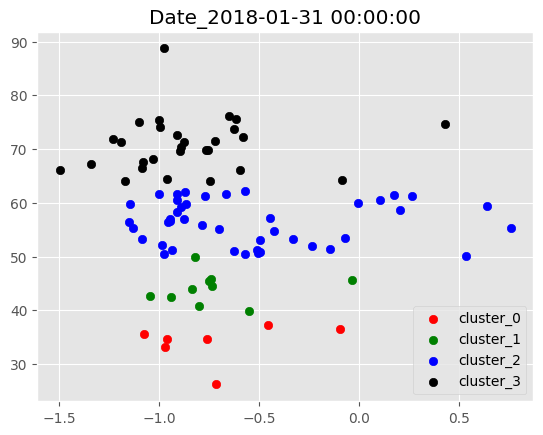

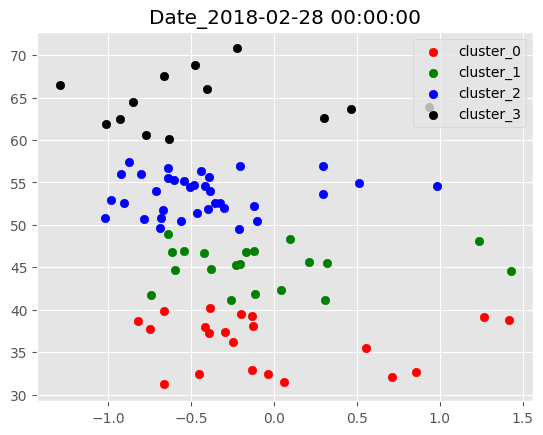

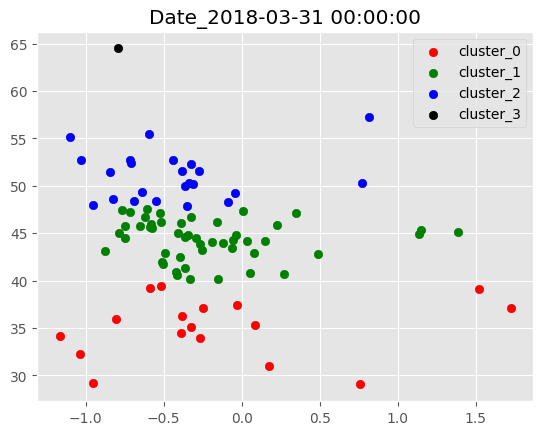

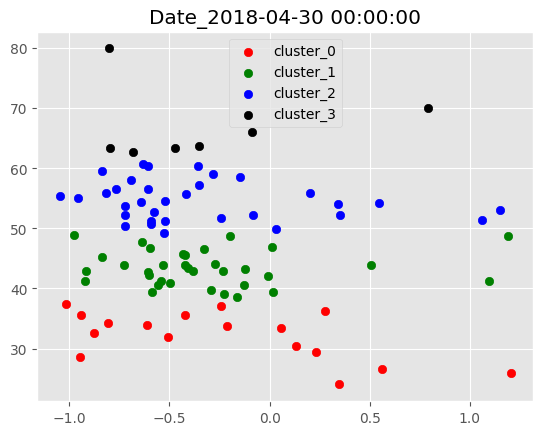

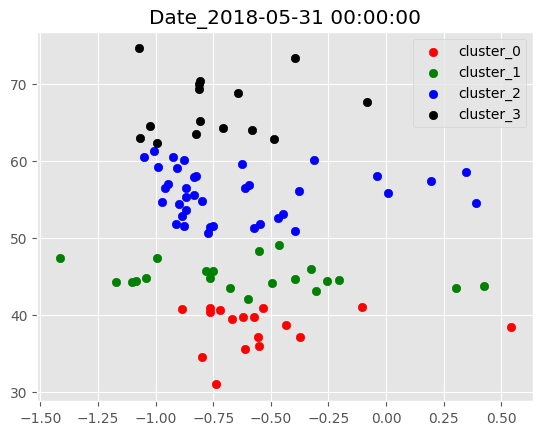

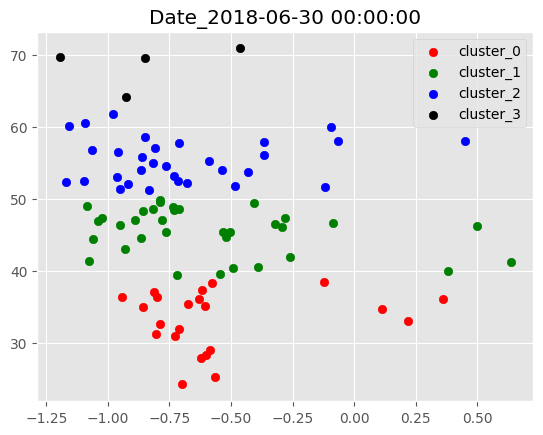

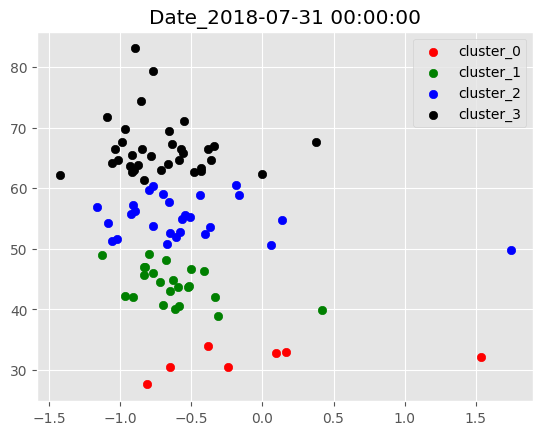

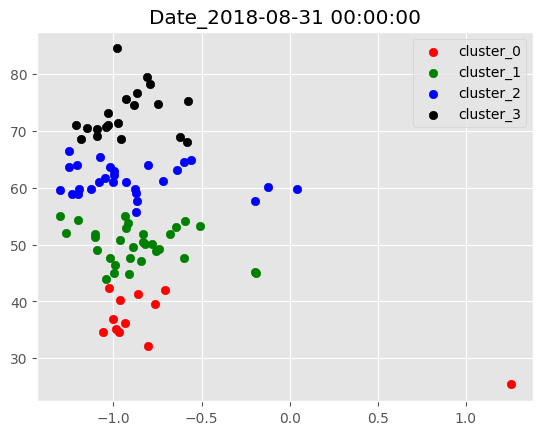

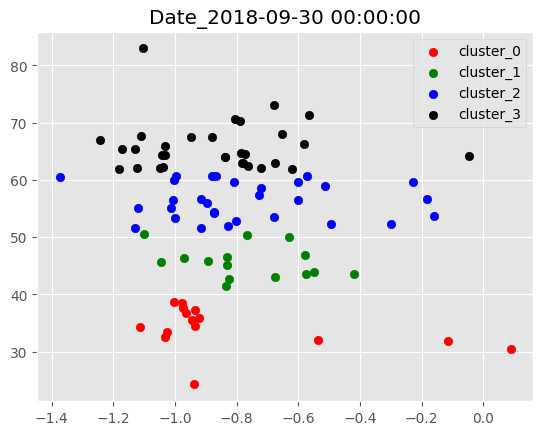

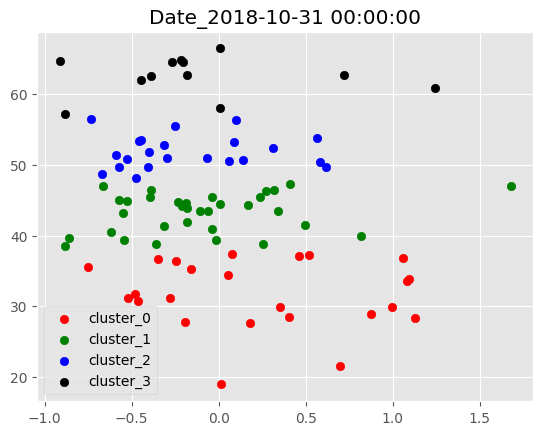

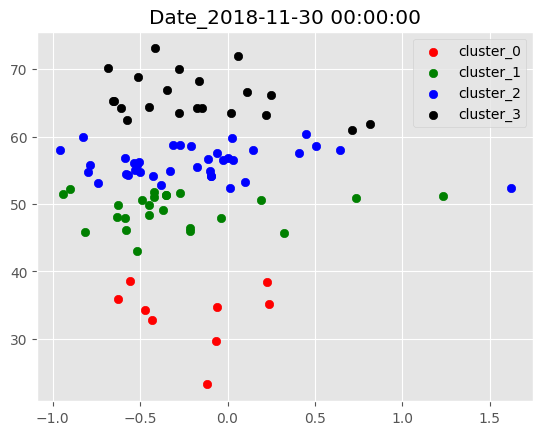

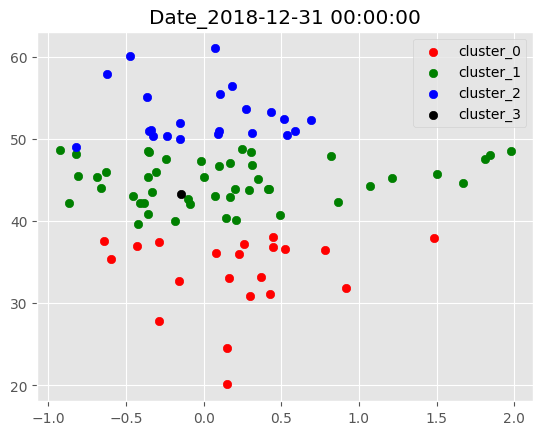

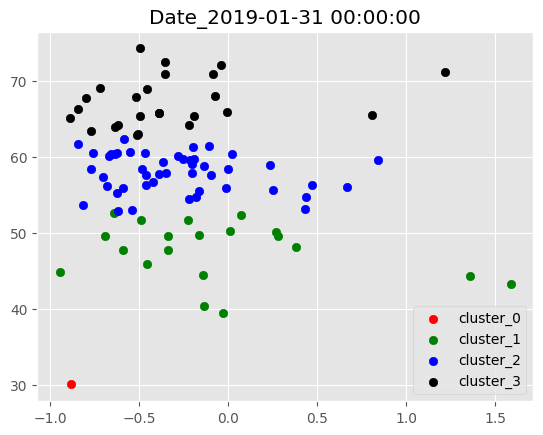

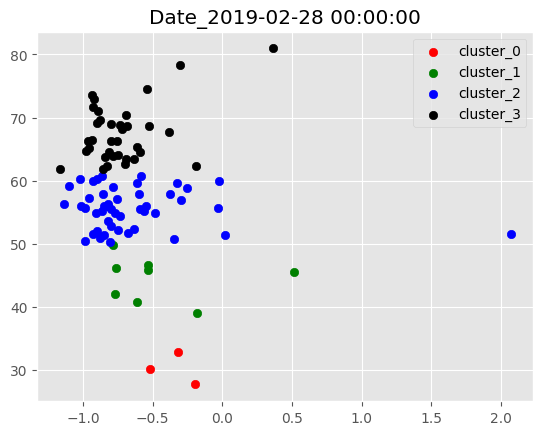

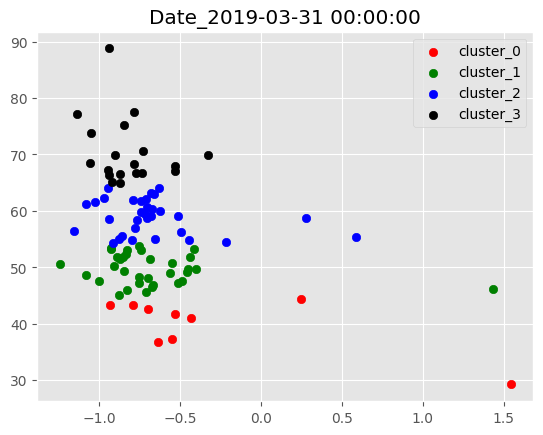

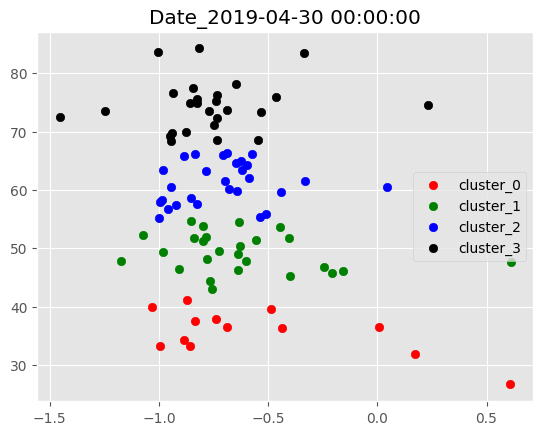

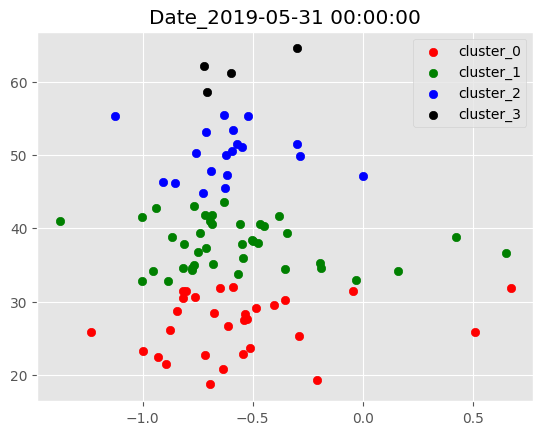

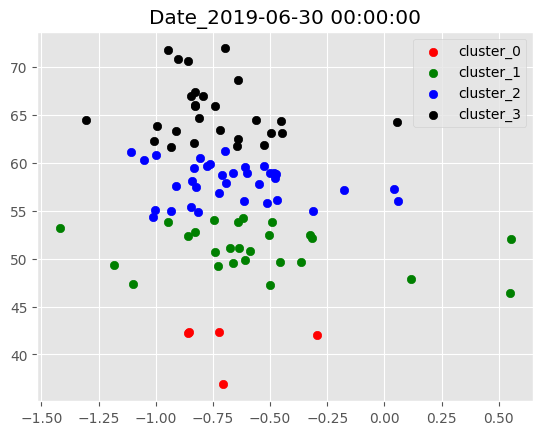

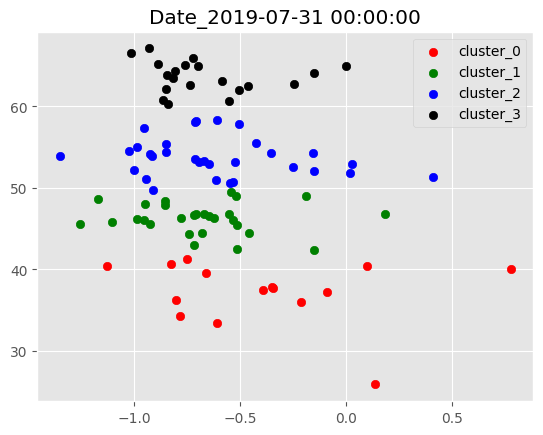

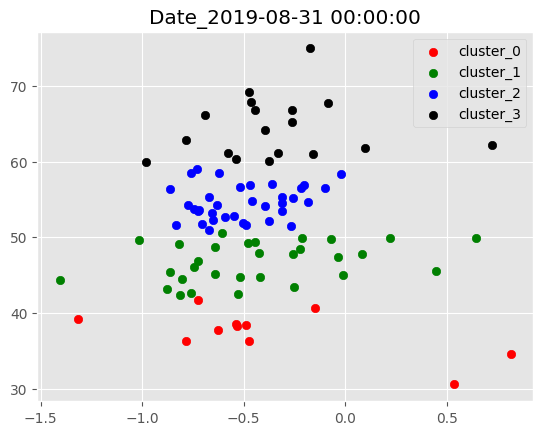

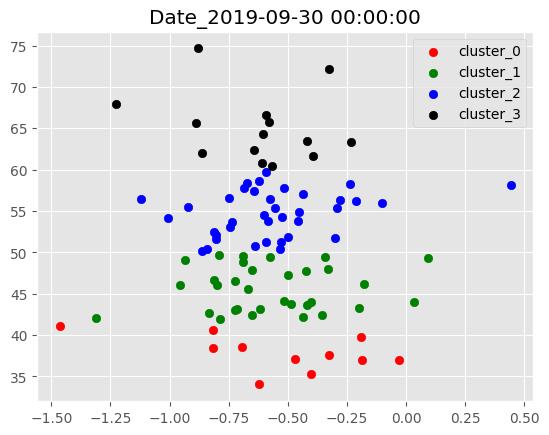

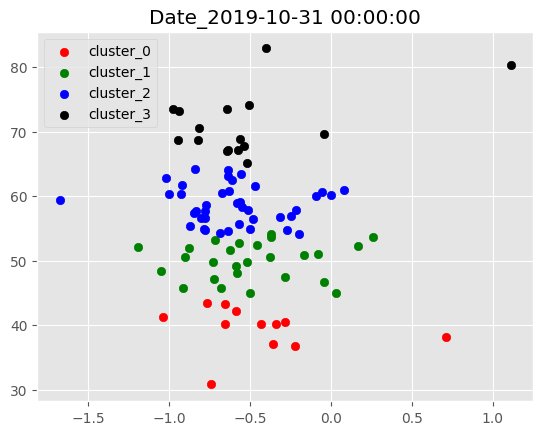

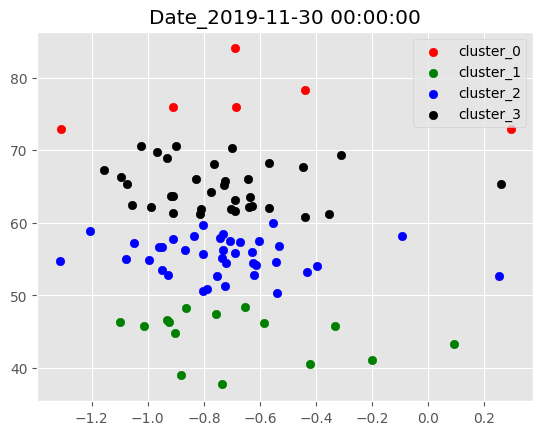

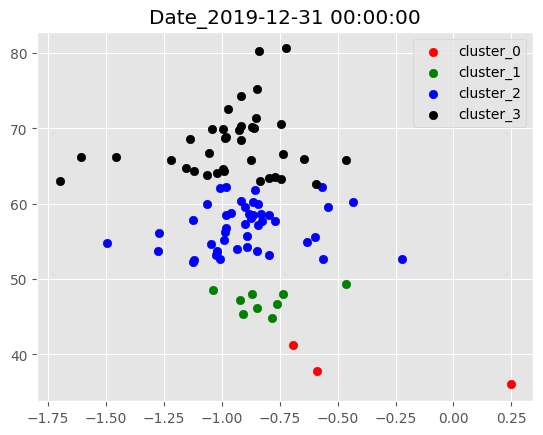

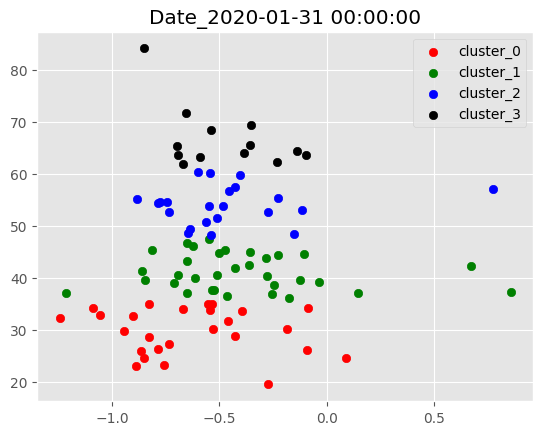

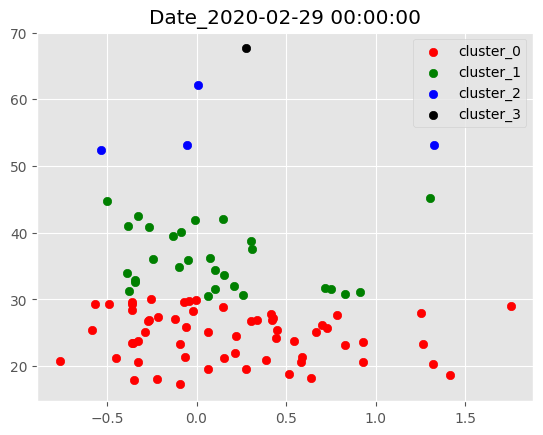

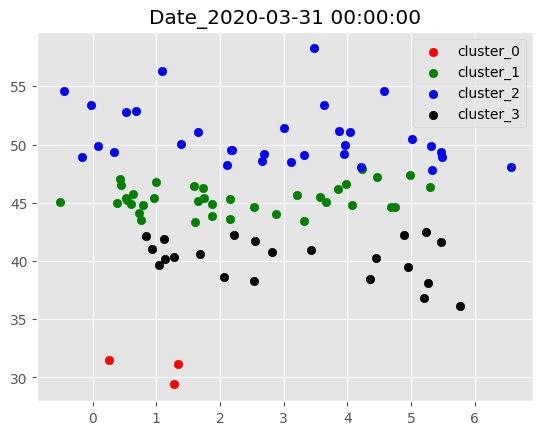

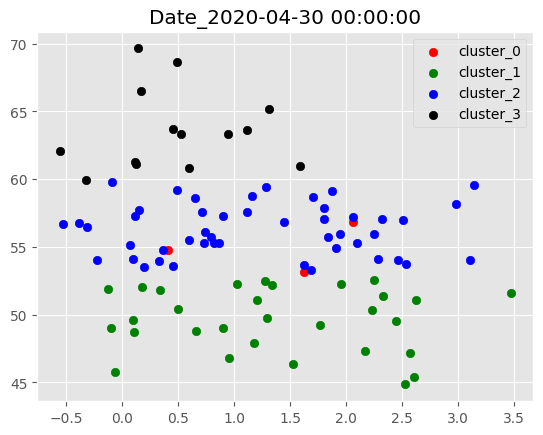

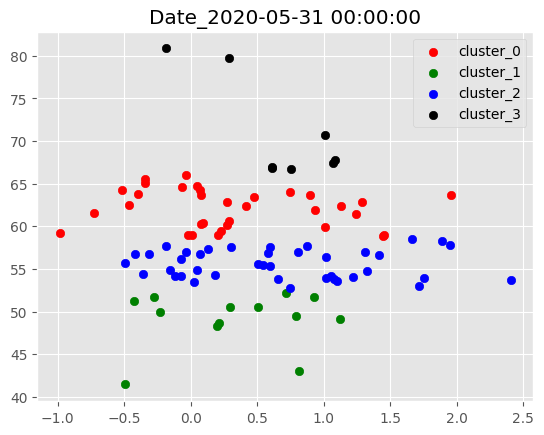

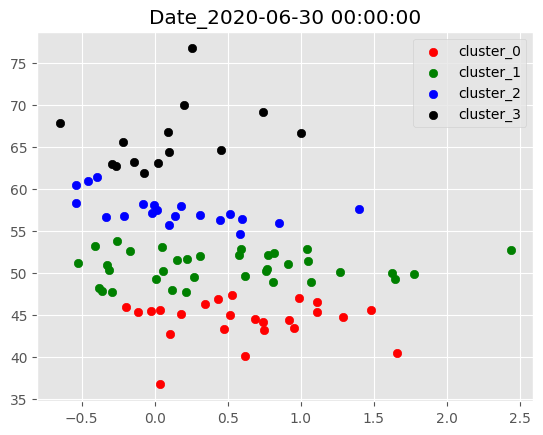

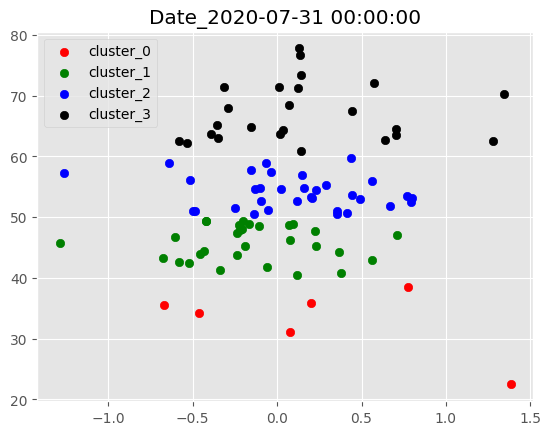

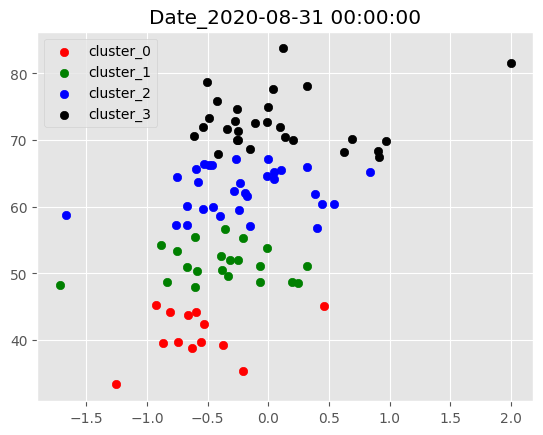

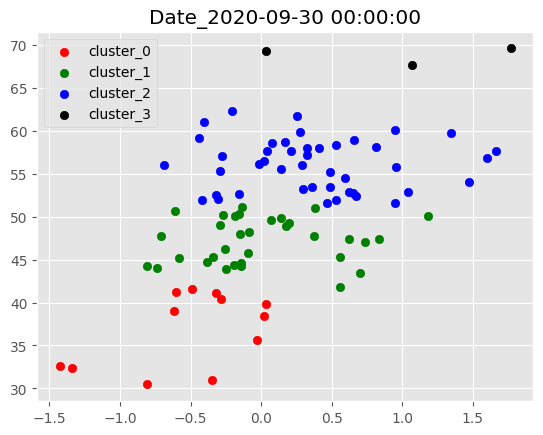

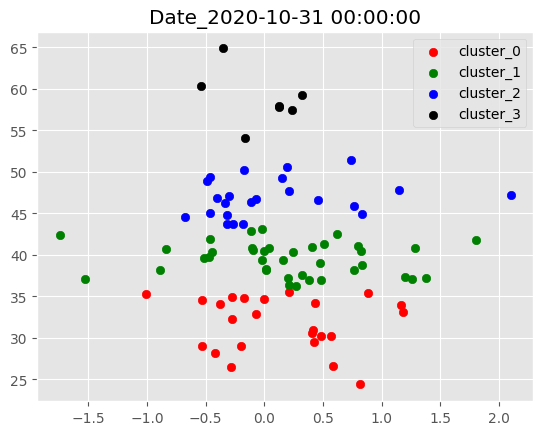

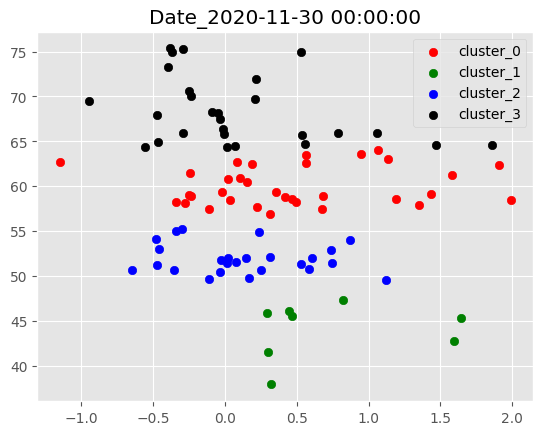

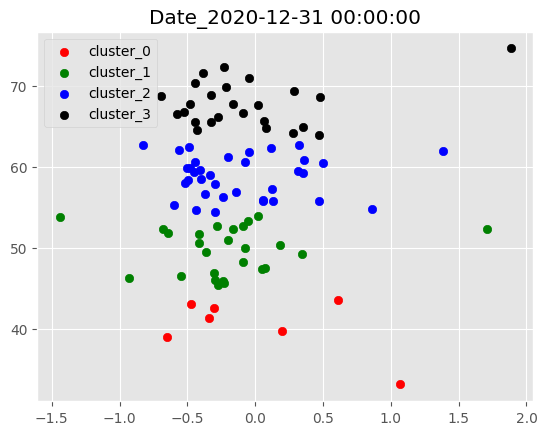

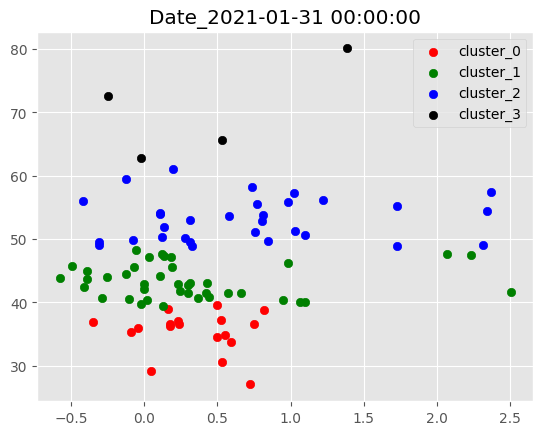

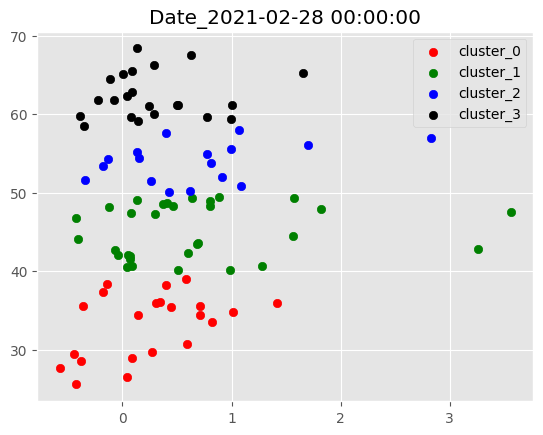

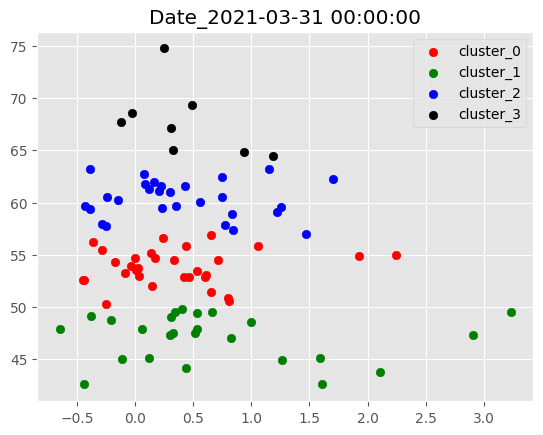

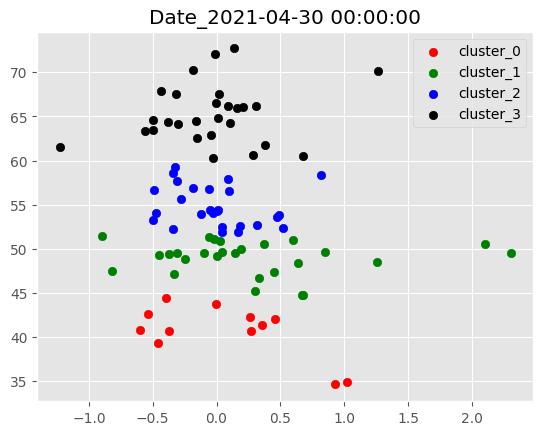

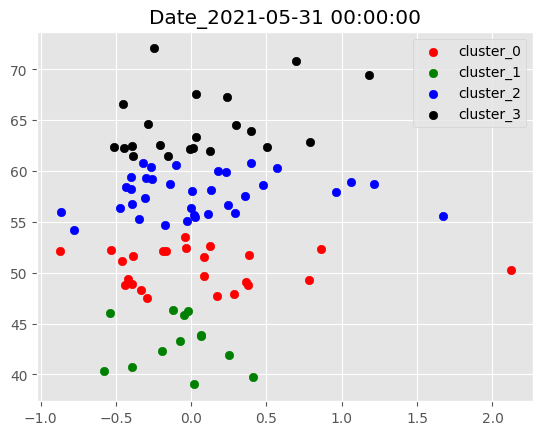

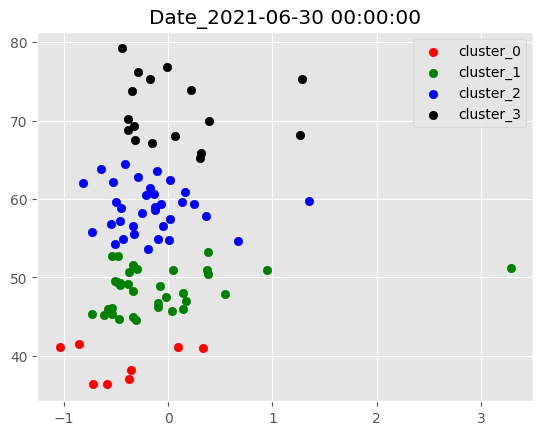

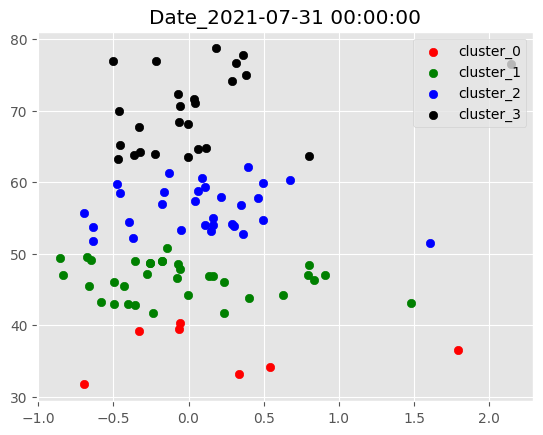

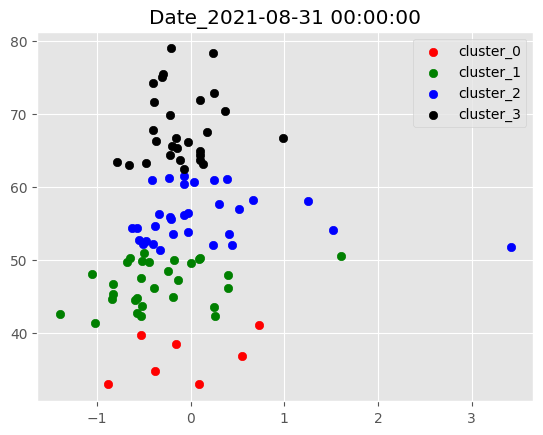

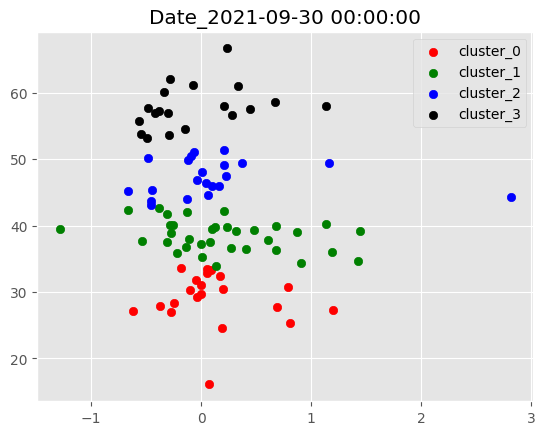

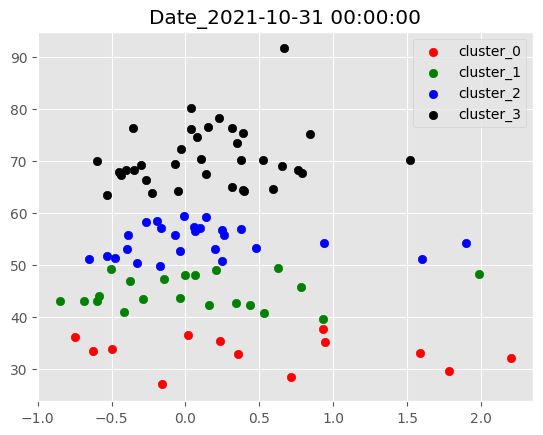

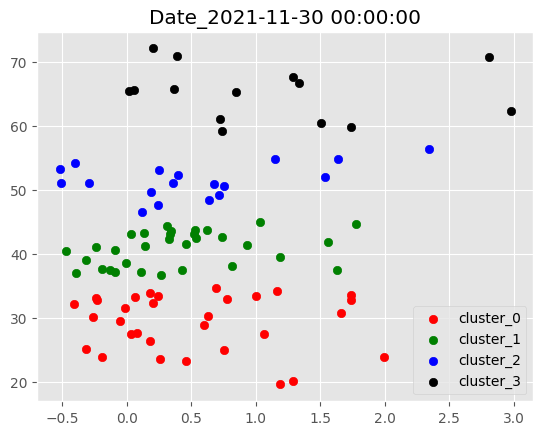

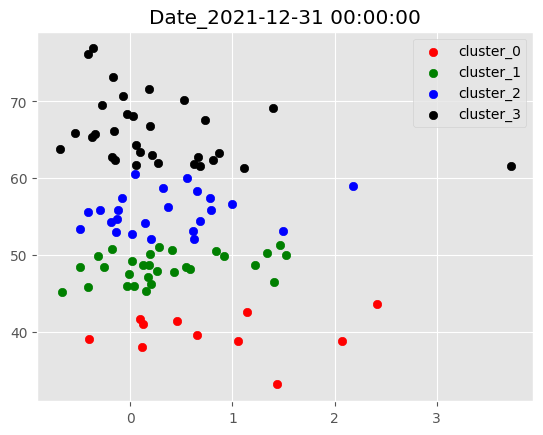

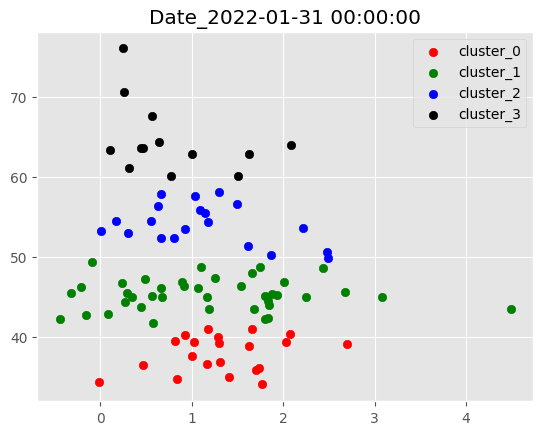

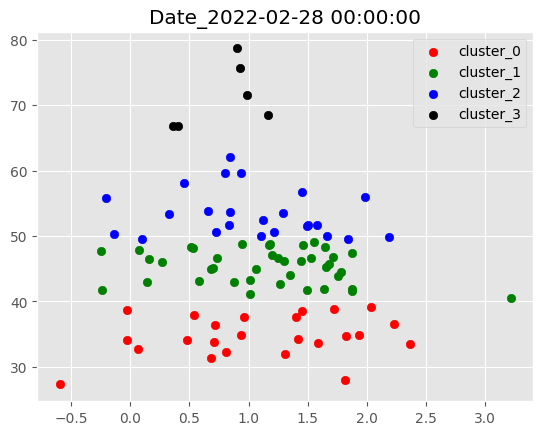

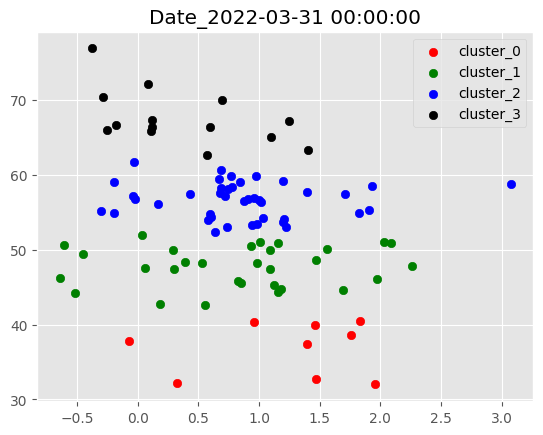

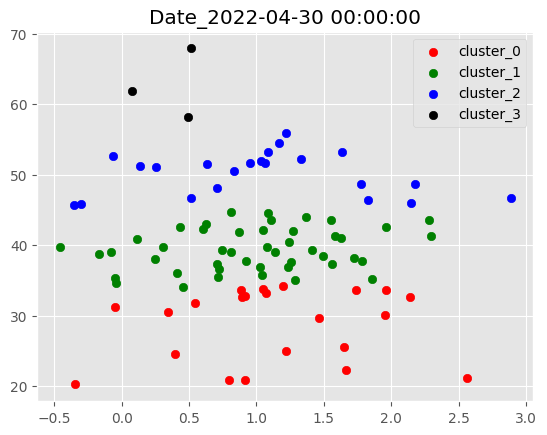

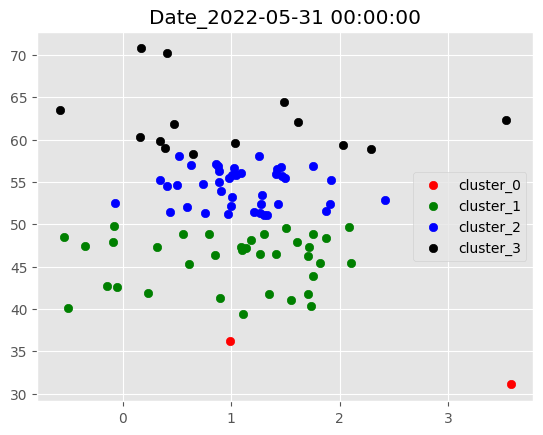

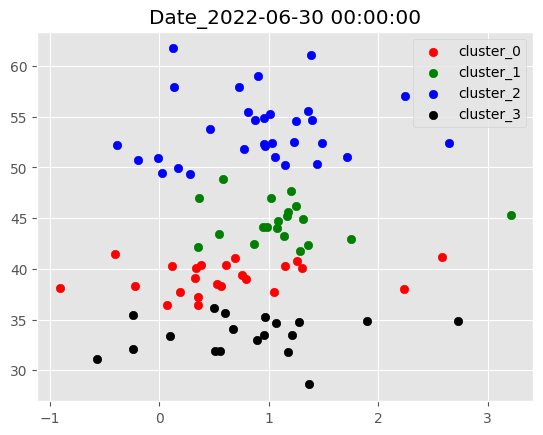

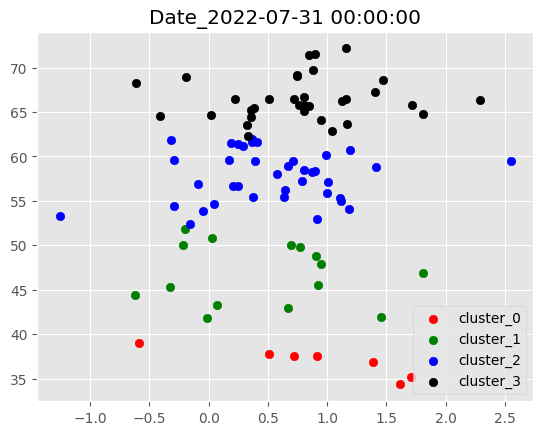

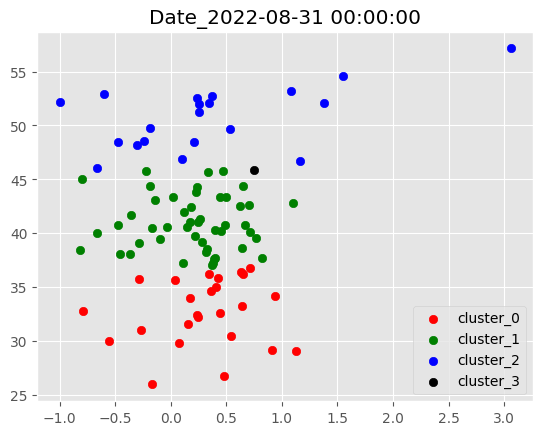

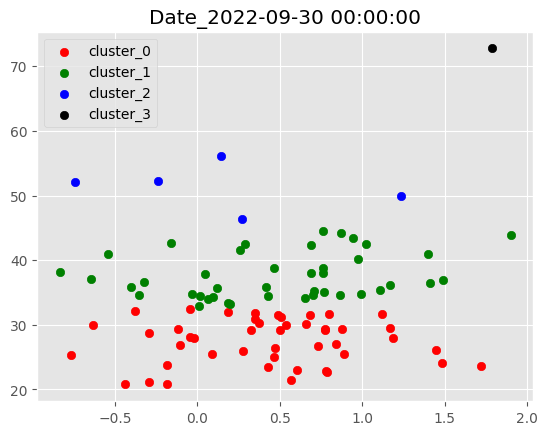

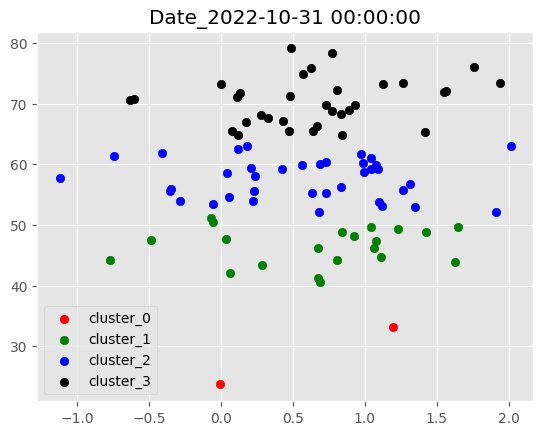

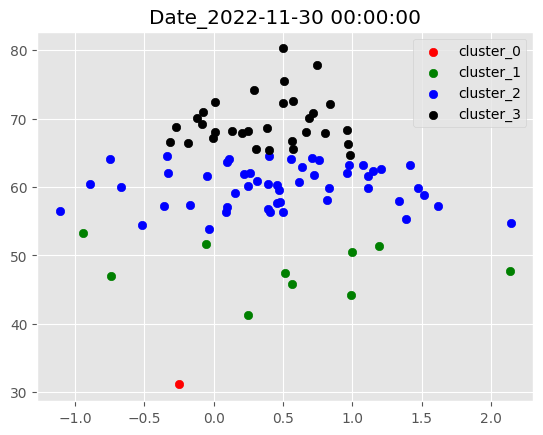

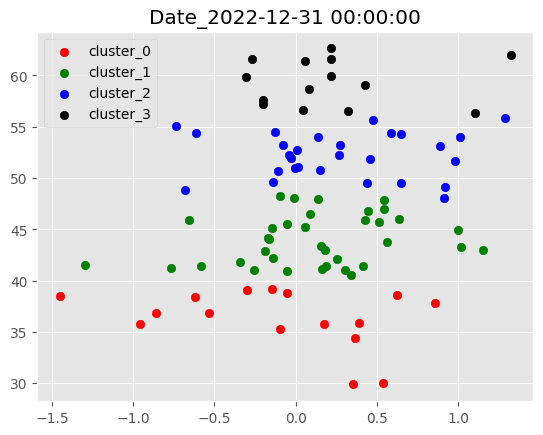

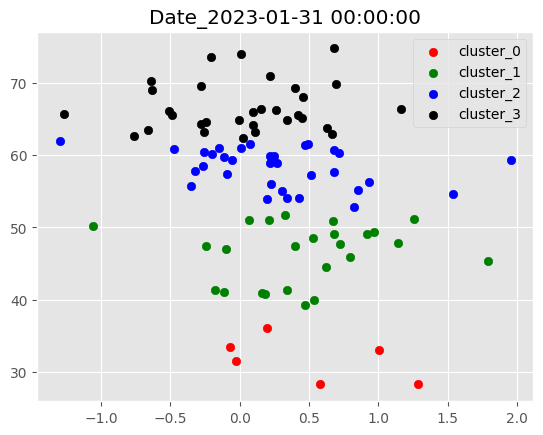

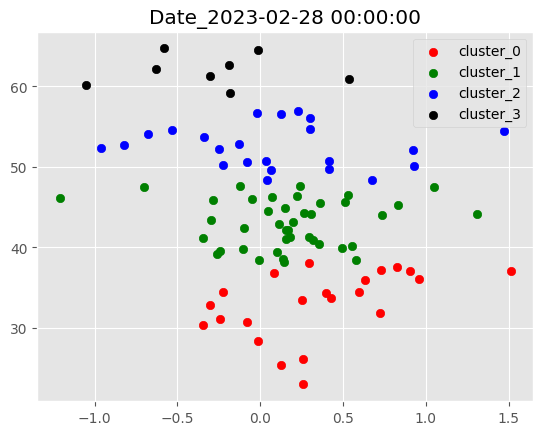

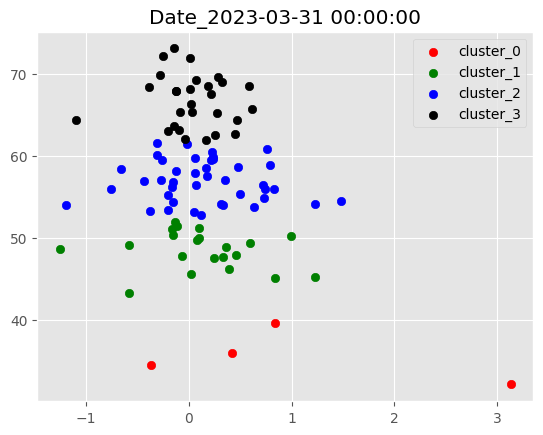

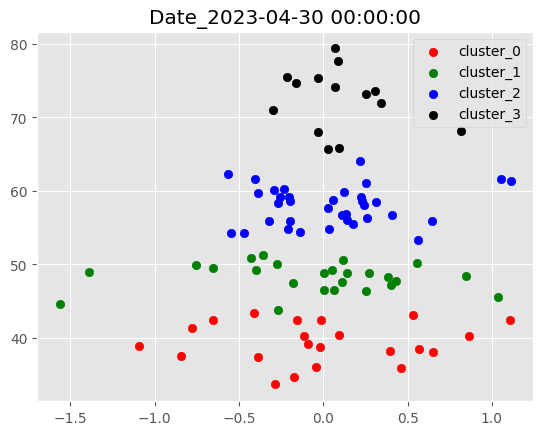

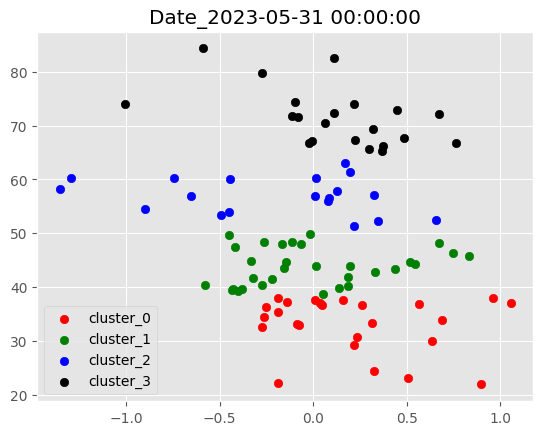

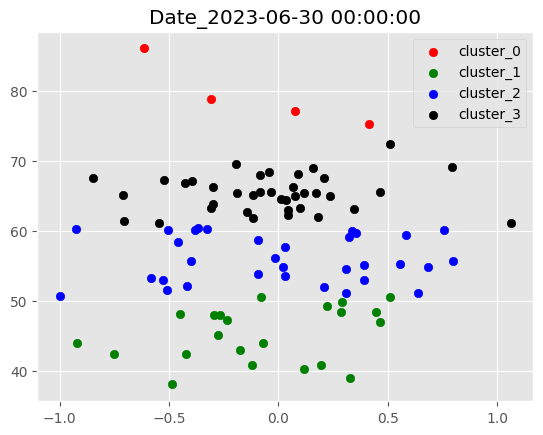

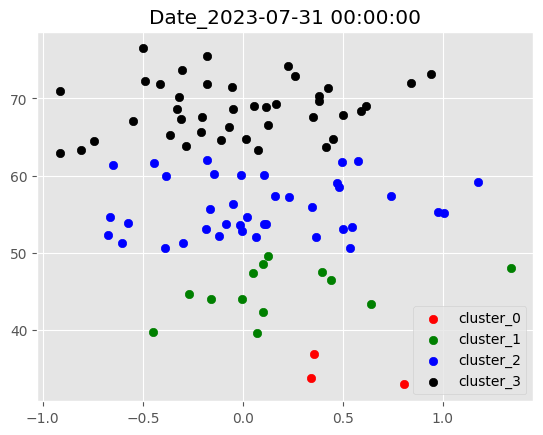

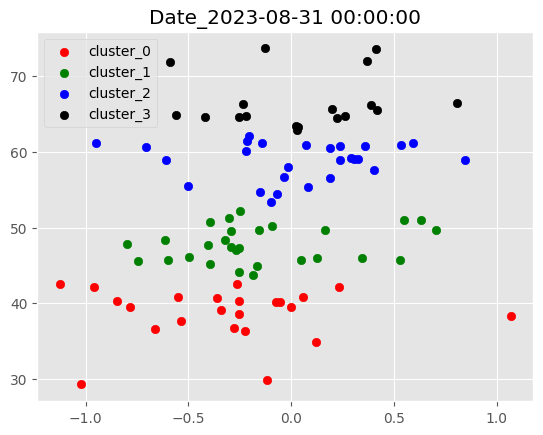

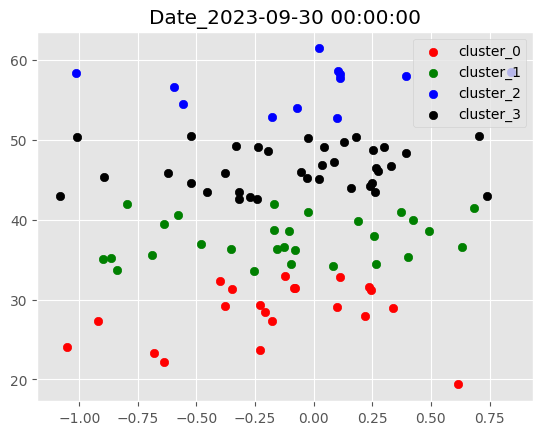

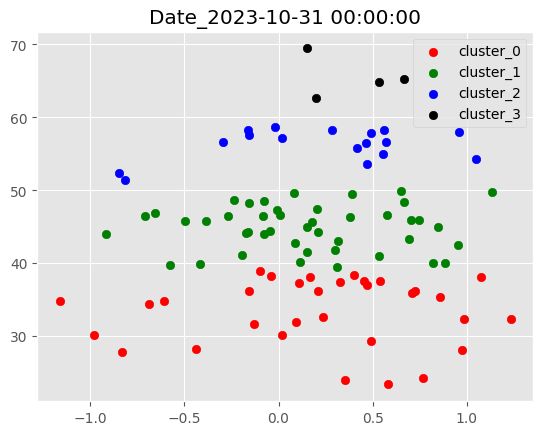

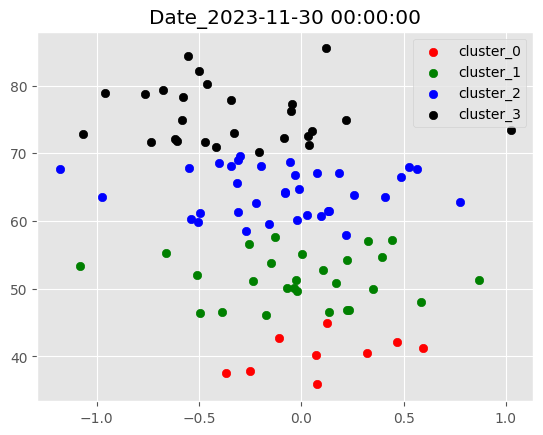

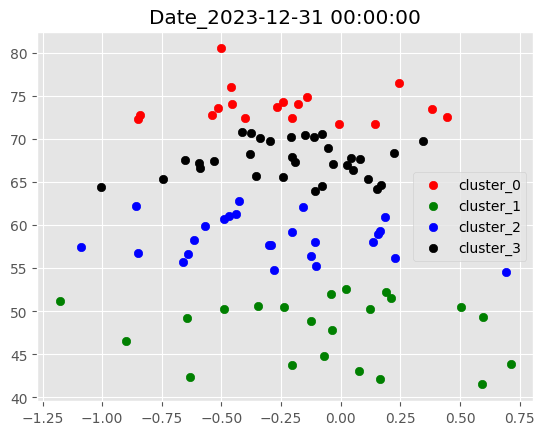

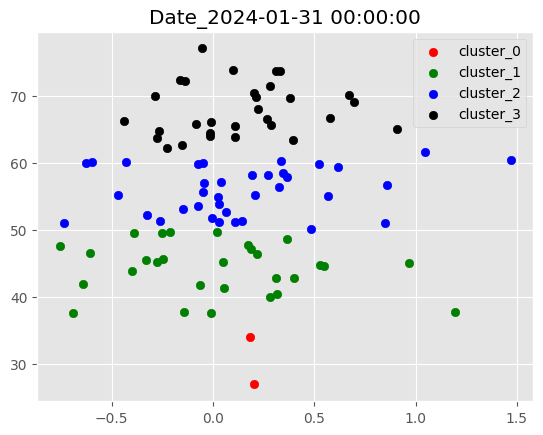

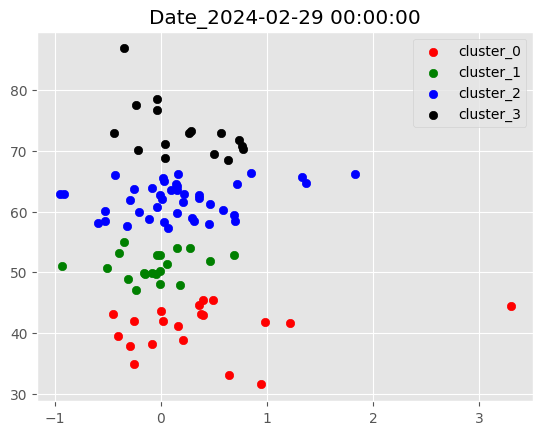

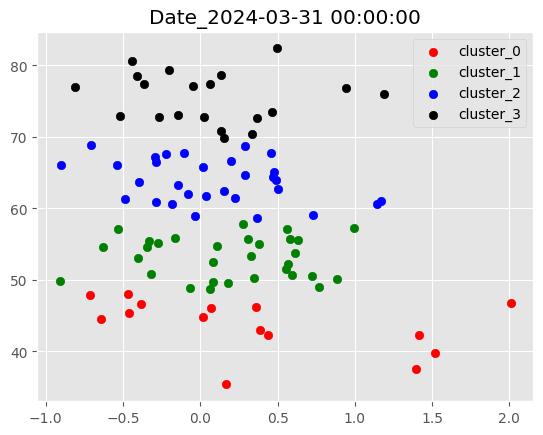

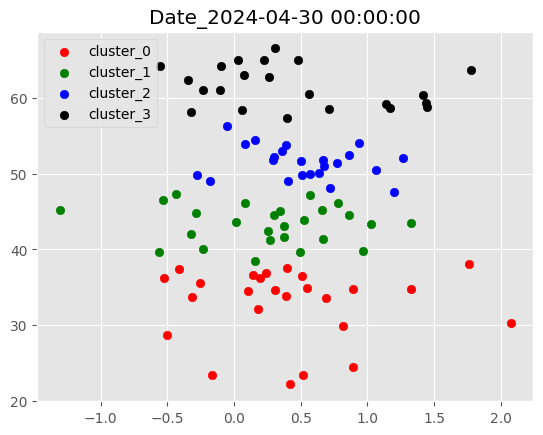

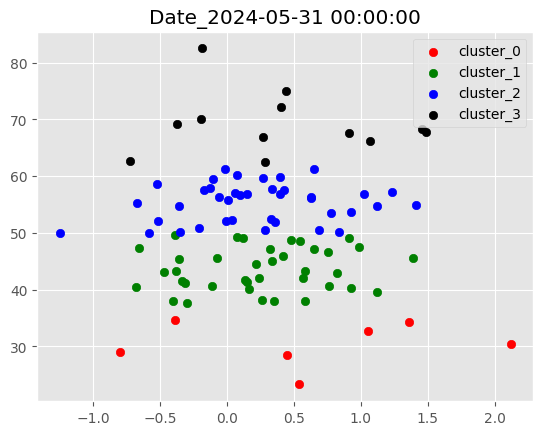

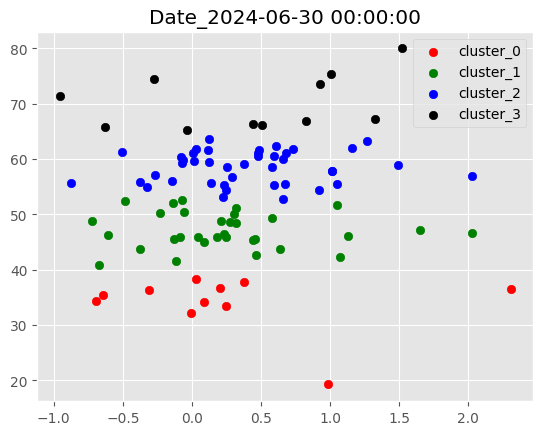

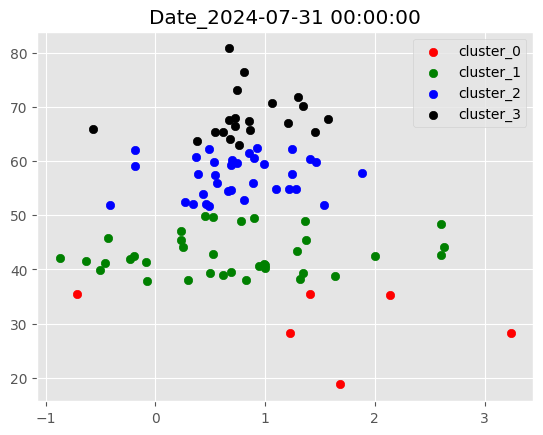

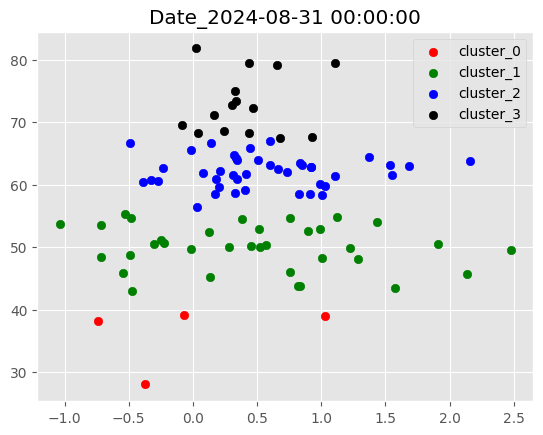

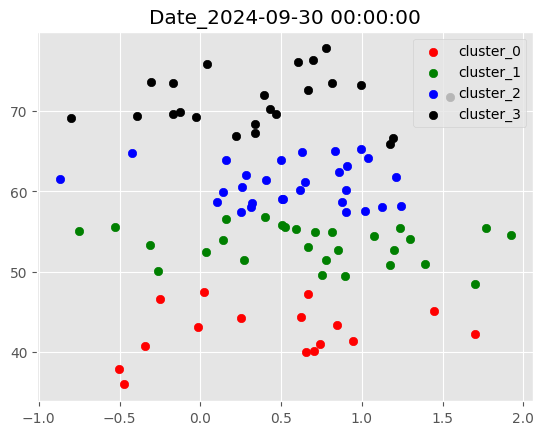

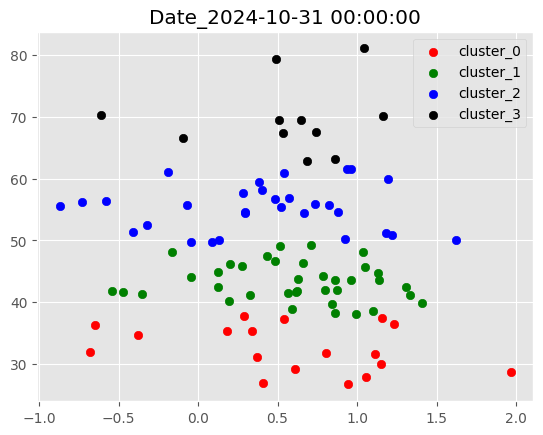

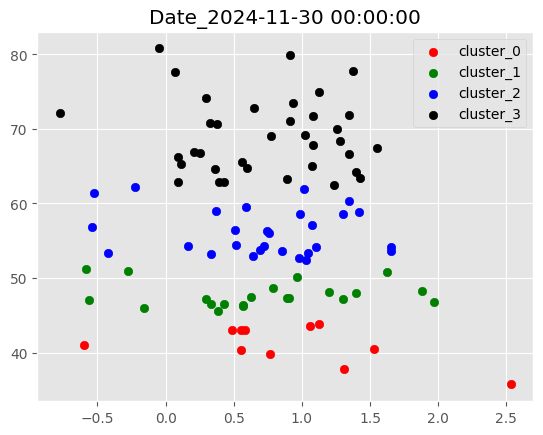

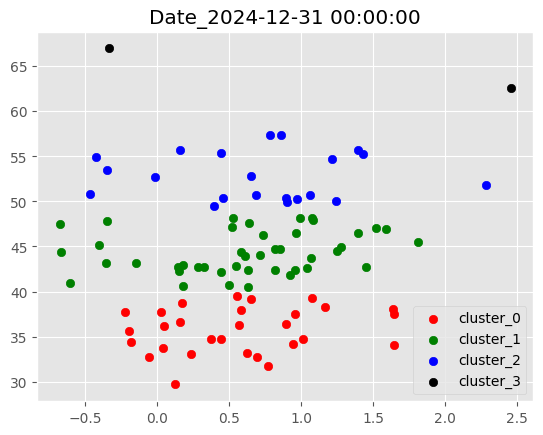

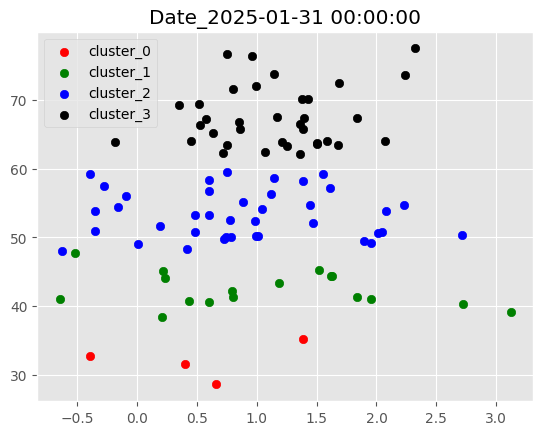

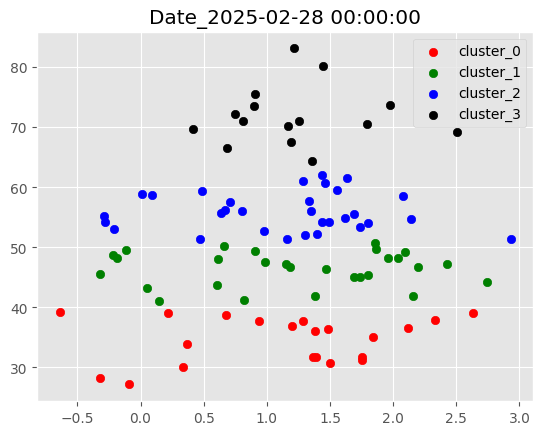

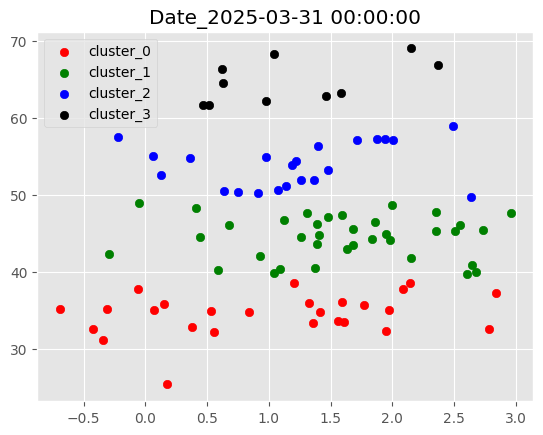

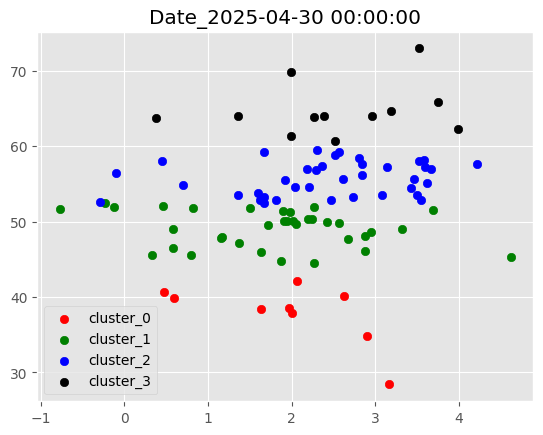

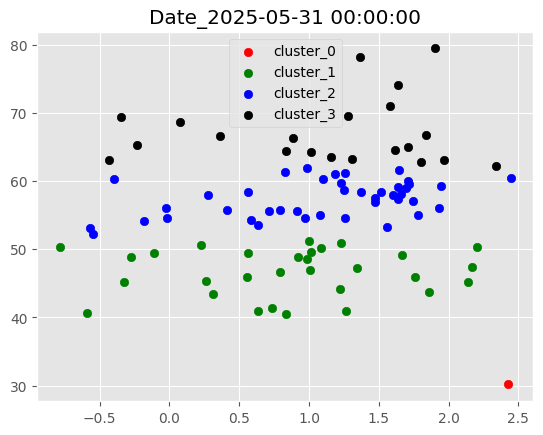

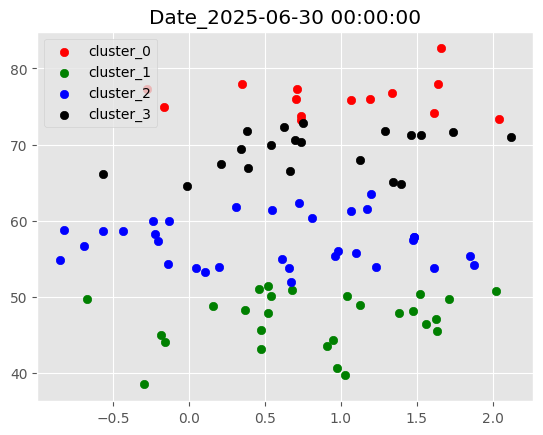

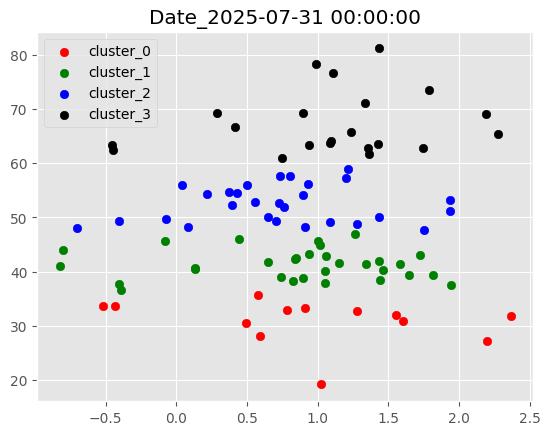

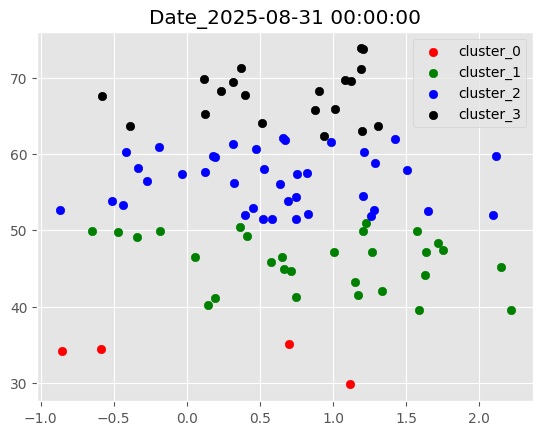

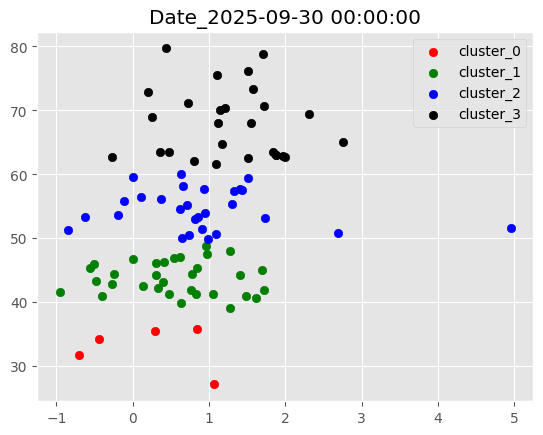

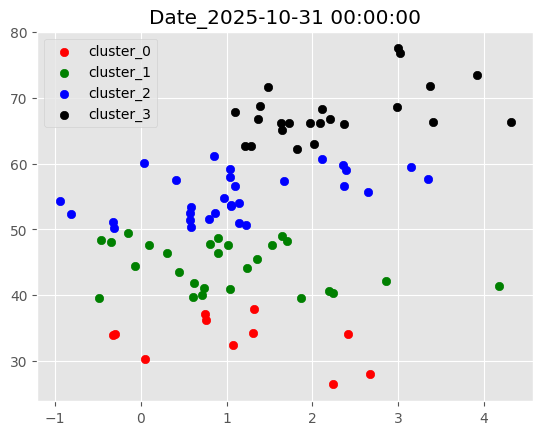

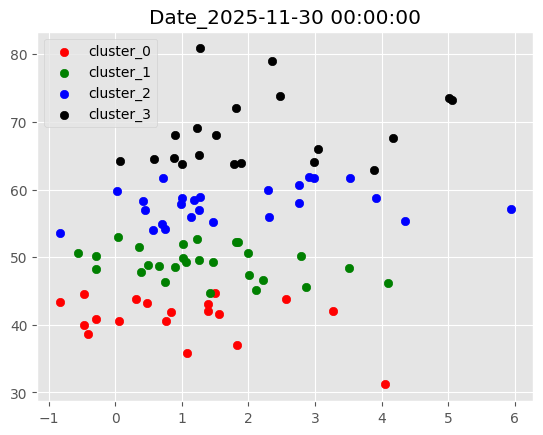

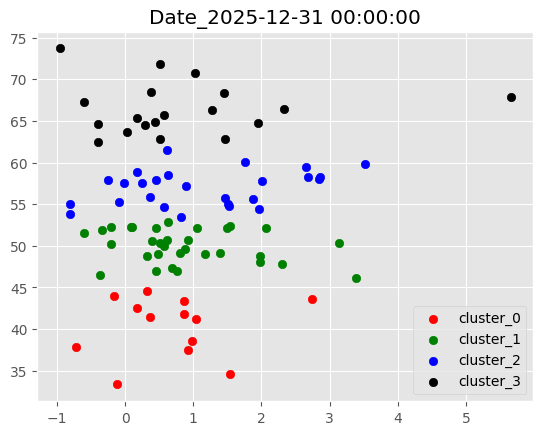

In [218]:
plt.style.use("ggplot")

for i in cluster_data.index.get_level_values("date").unique().tolist():

  g = cluster_data.xs(i, level=0)

  plt.title(f"Date_{i}")

  plot_cluster(g)

## Building Our Portfolio

In [265]:
"""

Our hypothesis is that, stocks with rsi around 70 (cluster 3) have highest momentum
 so they will keep outperforming in the next month as well. Because of that we
  will select these stocks for the next month in our portfolio

"""

'\n\nOur hypothesis is that, stocks with rsi around 70 (cluster 3) have highest momentum\n so they will keep outperforming in the next month as well. Because of that we\n  will select these stocks for the next month in our portfolio\n\n'

**Selecting the Stocks in the Cluster 3 only for each month**

In [266]:
filtered_df = cluster_data[cluster_data['cluster']==3].copy()

In [267]:
filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-01-31 ABT             0.000082  69.601610  3.911991  3.972297  4.032604   
           ADBE            0.000156  66.465844  5.202284  5.268046  5.333808   
           AMZN            0.000119  88.708274  4.088448  4.199492  4.310536   
           BA              0.000231  74.706992  5.652959  5.754136  5.855313   
           BAC             0.000055  71.946270  3.241267  3.291855  3.342443   
...                             ...        ...       ...       ...       ...   
2025-12-31 MU              0.000247  67.838228  5.370907  5.545372  5.719837   
           SCHW            0.000047  64.866686  4.520191  4.583693  4.647196   
           SPGI            0.000045  68.497015  6.175351  6.230973  6.286595   
           V               0.000019  65.713534  5.770046  5.835980  5.901914   
           WFC             0.000037  66.331765  4.475803  4.527971  4.580139   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-01-31 ABT    -0.893921  0.912980   0.094397   0.052610   0.048209   
           ADBE   -1.084157  0.503667   0.139922   0.049184   0.044779   
           AMZN   -0.977372  0.954003   0.240639   0.110389   0.094933   
           BA      0.429301  1.830389   0.201621   0.131476   0.113610   
           BAC    -1.231020  0.820407   0.084011   0.065814   0.054715   
...                     ...       ...        ...        ...        ...   
2025-12-31 MU      5.660257  5.323697   0.237941   0.143790   0.205238   
           SCHW    0.432391  1.444696   0.084331   0.032868   0.018393   
           SPGI    0.384945  1.533865   0.057855   0.041736   0.027986   
           V       0.566921  1.914632   0.057350   0.019733   0.012479   
           WFC     1.271890  2.193550   0.098544   0.044078   0.041908   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 ABT      0.041483   0.040852    0.035516  0.828798 -0.216370   
           ADBE     0.053053   0.045588    0.048329  1.308730 -0.491492   
           AMZN     0.066176   0.051289    0.048331  1.238474 -0.439023   
           BA       0.067304   0.077266    0.065778  1.079246  1.235719   
           BAC      0.049879   0.037140    0.030600  1.330926 -0.229728   
...                      ...        ...         ...       ...       ...   
2025-12-31 MU       0.155397   0.128237    0.095354  3.137735 -2.409264   
           SCHW     0.017283   0.029221    0.026908  1.009444 -0.248464   
           SPGI     0.000744   0.004833    0.005449  0.646703  0.297164   
           V       -0.000050   0.001598    0.010002  0.559822 -0.325843   
           WFC      0.029453   0.032680    0.026697  1.059299 -0.210036   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 ABT    -0.285340 -0.005242  0.947374        3  
           ADBE   -0.132628  0.083691 -0.503004        3  
           AMZN   -0.501511 -0.529297 -0.420765        3  
           BA     -0.061335  0.258954  0.342974        3  
           BAC     1.314922 -0.655235 -0.533902        3  
...                     ...       ...       ...      ...  
2025-12-31 MU      1.776006 -2.307386  0.621416        3  
           SCHW    0.439486 -1.010990 -0.001221        3  
           SPGI    0.281727  0.519142 -0.133116        3  
           V       0.425380 -0.110199  0.105020        3  
           WFC     0.576063 -1.345248  0.076754        3  

[1839 rows x 19 columns]

### Build a dictionary that have list of stocks to invest at the begining of each month

In [268]:
"""

Here we want to build a dictionary that show us the list of stocks to invest on
 at begining of each month

"""


"""
moving the date one day forward to make the date appeare as first day of
 the next month
"""

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)


"""
Returning everything back
"""

filtered_df = filtered_df.reset_index().set_index(["date", "ticker"])


"""
building the dectionary
"""

dates = filtered_df.index.get_level_values("date").unique().tolist()

fixed_dates = {}

for d in dates:

  fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d, level=0).index.tolist()

In [269]:
fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'EBAY',
  'GOOG',
  'GOOGL',
  'JPM',
  'LMT',
  'LOW',
  'MA',
  'MDLZ',
  'MS',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PYPL',
  'RTX',
  'V',
  'VZ',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMAT',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI'],
 '2018-04-01': ['COP'],
 '2018-05-01': ['CMG', 'COP', 'COST', 'CVS', 'CVX', 'HAL', 'MCD'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'AVGO',
  'BIIB',
  'CMG',
  'CSX',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NFLX',
  'PYPL',
  'QCOM',
  'TXN'],
 '2018-07-01': ['COST', 'NKE', 'PEP', 'REGN'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'BAC',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'DIS',
  'GILD',
  'GS',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LMT',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'TG

### Define portfolio optimization function (Efficient Frontier Optimizer)

In [270]:
"""
In this function, we have to enter prices for one year to get the best weights
"""


"""
frequency=252 is number of days

cov is coveriance

ef is Efficient Frontier

weight_bounds is the range weight of each stock
"""

def optimize_weights(price, lower_bond=0):

  returns = expected_returns.mean_historical_return(prices=price,
                                                    frequency=252)

  cov = risk_models.sample_cov(prices=price, frequency=252)

  ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov,
                         weight_bounds=(lower_bond,0.1), solver="SCS")

  weights = ef.max_sharpe()

  return ef.clean_weights()

In [271]:
cluster_data.index.get_level_values("date").unique()[0]-pd.DateOffset(months=12)

Timestamp('2017-01-31 00:00:00')

In [272]:
cluster_data.index.get_level_values("date").unique()[-1]

Timestamp('2025-12-31 00:00:00')

In [273]:
"""
here we will download the prices of our stocks for one year
"""

stocks = cluster_data.index.get_level_values("ticker").unique().tolist()

stocks_df = yf.download(tickers=stocks,
                     start=cluster_data.index.get_level_values("date").unique()[0]-pd.DateOffset(months=12),
                     end=cluster_data.index.get_level_values("date").unique()[-1])

[*********************100%***********************]  113 of 113 completed


In [274]:
stocks_df

Price            Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2017-01-31   27.943258   41.963825         NaN   35.518661   99.189331   
2017-02-01   29.647259   41.812763         NaN   35.994843   98.614395   
2017-02-02   29.596600   41.812763         NaN   36.351982   98.988960   
2017-02-03   29.723240   41.661686         NaN   36.377491   99.729393   
2017-02-06   30.001867   41.647968         NaN   36.079884   99.459351   
...                ...         ...         ...         ...         ...   
2025-12-23  272.105377  226.963898  136.490005  123.912323  270.769989   
2025-12-24  273.554016  228.055130  136.779999  124.180954  269.980011   
2025-12-26  273.144409  228.144394  136.820007  124.210808  271.089996   
2025-12-29  273.504089  228.997543  136.619995  123.942169  271.339996   
2025-12-30  272.824707  227.906326  136.910004  125.146072  270.000000   

Price                                                                   ...  \
Ticker            ADBE        AMAT         AMD        AMGN        AMZN  ...   
Date                                                                    ...   
2017-01-31  113.379997   30.992836   10.370000  118.636963   41.174000  ...   
2017-02-01  113.360001   31.698654   12.060000  120.900963   41.617500  ...   
2017-02-02  113.160004   31.617220   12.280000  120.832840   41.997501  ...   
2017-02-03  115.169998   31.952023   12.240000  126.852493   40.509998  ...   
2017-02-06  114.459999   31.834391   13.630000  126.133179   40.382000  ...   
...                ...         ...         ...         ...         ...  ...   
2025-12-23  352.420013  260.230011  214.899994  329.208862  232.139999  ...   
2025-12-24  352.980011  260.779999  215.039993  331.661865  232.380005  ...   
2025-12-26  353.799988  261.899994  214.990005  330.638947  232.520004  ...   
2025-12-29  353.160004  263.049988  215.610001  327.361664  232.070007  ...   
2025-12-30  352.510010  259.970001  215.339996  326.428131  232.529999  ...   

Price           Volume                                                  \
Ticker            UBER      UNH      UNP         V        VZ       WFC   
Date                                                                     
2017-01-31         NaN  3037000  4534600   7479400  16844200  22409100   
2017-02-01         NaN  3718500  4374500   7534400  26004100  21157700   
2017-02-02         NaN  4714000  4225900  11142300  17787200  13044400   
2017-02-03         NaN  2762300  3249600  28079600  15166400  19879800   
2017-02-06         NaN  3479400  2858100   9665300  16151400  13940200   
...                ...      ...      ...       ...       ...       ...   
2025-12-23  10445500.0  4463300  1980700   3703200  19761800   8642100   
2025-12-24   4310700.0  2842700   921900   2023600   7949500   5506800   
2025-12-26   6741600.0  4359300   902500   2017000  11875400   5169400   
2025-12-29  12072600.0  4346800  1554100   3989900  16846700   8624200   
2025-12-30   9500700.0  4432500  1884300   3366500  15581300   6417800   

Price                                             
Ticker           WMT     WYNN       XOM      XYZ  
Date                                              
2017-01-31  27962700  1827500  19128100  3124100  
2017-02-01  27150000  3025400  15111800  4679000  
2017-02-02  26996100  1698700  12200100  2376200  
2017-02-03  22875900  1888800  12746300  3632200  
2017-02-06  27291600  2828800   9938200  3157400  
...              ...      ...       ...      ...  
2025-12-23  20319900  1096700  12567600  5068200  
2025-12-24   9009600   615000   6137400  3017700  
2025-12-26   9003800   717300   8066100  3118400  
2025-12-29  12979600  1017200  14782500  4216700  
2025-12-30  11730600   689900  11150500  2958800  

[2242 rows x 565 columns]

In [275]:
"""
calculate the returns of each stock during the selected period
"""

returns_portfolio = np.log(stocks_df["Close"]).diff()

In [276]:
returns_portfolio.head()

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,AMAT,AMD,AMGN,AMZN,...,UBER,UNH,UNP,V,VZ,WFC,WMT,WYNN,XOM,XYZ
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,0.059194,-0.003606,NaN,0.013317,-0.005813,-0.000176,0.022518,0.150977,0.018904,0.010714,...,NaN,0.003756,0.010454,-0.003270,-0.012731,-0.000715,-0.007671,-0.035831,-0.011389,-0.017944
2017-02-02,-0.001710,0.000000,NaN,0.009873,0.003791,-0.001766,-0.002572,0.018078,-0.000564,0.009089,...,NaN,-0.012057,-0.003721,-0.001699,-0.002275,-0.002866,0.007071,-0.004917,0.006130,0.000000
2017-02-03,0.004270,-0.003620,NaN,0.000701,0.007452,0.017607,0.010534,-0.003263,0.048617,-0.036061,...,NaN,0.006881,0.011213,0.044906,0.006194,0.026899,-0.003003,-0.004735,0.001078,-0.005587
2017-02-06,0.009330,-0.000329,NaN,-0.008215,-0.002711,-0.006184,-0.003688,0.107564,-0.005687,-0.003165,...,NaN,-0.008437,-0.007585,-0.002909,-0.011386,-0.012652,-0.001505,0.001031,-0.002757,0.008368


In [277]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():


    start_dt = pd.to_datetime(start_date)
    end_date = (start_dt + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")

    selected_stocks = fixed_dates[start_date]
    n_stocks = len(selected_stocks)

    equal_weight = 1.0 / n_stocks

    month_returns = returns_portfolio.loc[start_date:end_date, selected_stocks]


    temp_df = month_returns.multiply(equal_weight).sum(axis=1).to_frame('Portfolio Return')


    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

In [278]:
portfolio_df

,Portfolio Return
Date,
2018-02-01,0.001730
2018-02-02,-0.018476
2018-02-05,-0.046733
2018-02-06,0.020018
2018-02-07,-0.002020
...,...
2025-12-23,0.001031
2025-12-24,0.003643
2025-12-26,-0.000348


## Comparing the Portfolio vs. S&P 500 Index Returns

**Downloading the inedex data & calculate its returns**

In [279]:
spy = yf.download(tickers='SPY',
                  start='2018-02-01',
                  end="2025-12-30", multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [280]:
spy

,Close,High,Low,Open,Volume
Date,,,,,
2018-02-01,248.513916,249.820129,247.719609,248.063824,90102500
2018-02-02,243.103790,247.322472,243.068480,247.190065,173174800
2018-02-05,232.936615,243.456858,232.389426,241.338696,294681800
2018-02-06,237.525925,238.028996,228.320732,229.415109,355026800
2018-02-07,236.237411,240.376638,236.157957,236.969932,167376100
...,...,...,...,...,...
2025-12-22,684.830017,685.359985,680.590027,683.940002,69556700
2025-12-23,687.960022,688.200012,683.869995,683.919983,64840000
2025-12-24,690.380005,690.830017,687.799988,687.950012,39445600


In [281]:
spy_ret = np.log(spy[('Close')]).diff().dropna().to_frame('SPY Return')

In [282]:
spy_ret

,SPY Return
Date,
2018-02-02,-0.022010
2018-02-05,-0.042722
2018-02-06,0.019510
2018-02-07,-0.005439
2018-02-08,-0.038230
...,...
2025-12-22,0.006211
2025-12-23,0.004560
2025-12-24,0.003511


**Merging the two returns in one dataframe**

In [283]:
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

In [284]:
portfolio_df

,Portfolio Return,SPY Return
Date,,
2018-02-02,-0.018476,-0.022010
2018-02-05,-0.046733,-0.042722
2018-02-06,0.020018,0.019510
2018-02-07,-0.002020,-0.005439
2018-02-08,-0.042911,-0.038230
...,...,...
2025-12-22,0.006325,0.006211
2025-12-23,0.001031,0.004560
2025-12-24,0.003643,0.003511


In [285]:
"""
calculating the cumulative returns
"""

cum_returns = np.exp(np.log1p(portfolio_df).cumsum())-1

In [290]:
cum_returns

,Portfolio Return,SPY Return
Date,,
2018-02-02,-0.018476,-0.022010
2018-02-05,-0.064345,-0.063792
2018-02-06,-0.045615,-0.045526
2018-02-07,-0.047542,-0.050718
2018-02-08,-0.088413,-0.087010
...,...,...
2025-12-22,2.452595,1.366477
2025-12-23,2.456155,1.377269
2025-12-24,2.468744,1.385616


**Visualizing the two returns**

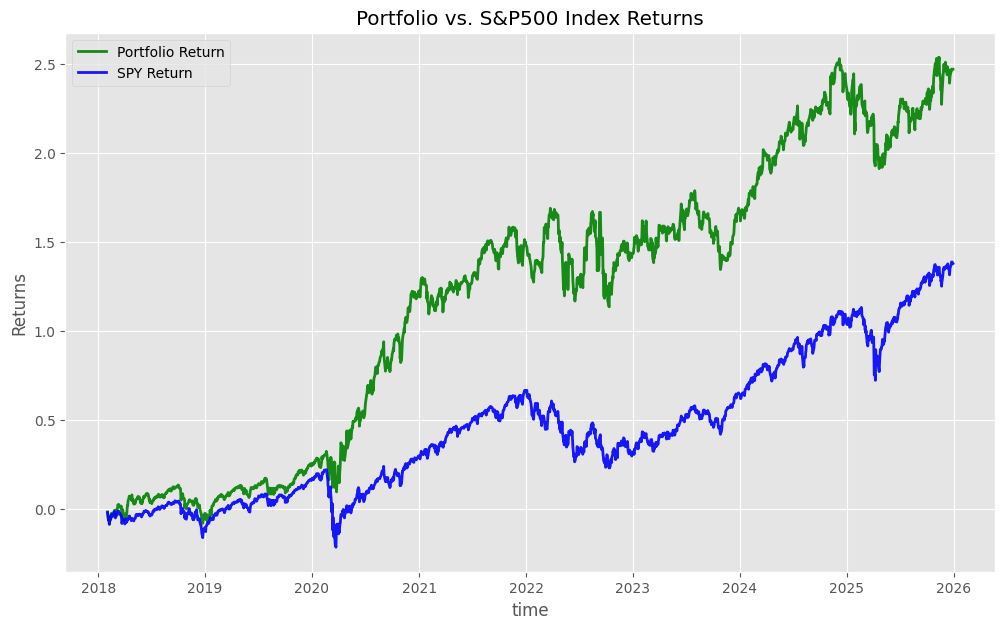

In [287]:
plt.figure(figsize=(12,7))
plt.plot(cum_returns['Portfolio Return'],"g-", markersize=5,
         linewidth=2, alpha=0.9, label="Portfolio Return")
plt.plot(cum_returns['SPY Return'],"b-", label="SPY Return",
         linewidth=2, alpha=0.9)
plt.xlabel("time")
plt.ylabel("Returns")
plt.title("Portfolio vs. S&P500 Index Returns")
plt.legend()
plt.savefig("portfolio.png", bbox_inches= "tight", pad_inches=2)
plt.show()